<a href="https://colab.research.google.com/github/Abdelrhman-Amr-98/Head-Pose-Estimation/blob/main/Project_Drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project was developed with the contribution of my fellow colleague and friend: Dina Zakaria

# You Can go directly to the step

1. [Imports](#Imports)
2. [Data Preparation](#DataPreparation)
3. [EDA & Model Generation](#EDA_ModelGen)
4. [Model](#Model)
5. [Deployment Phase](#Deployment)

  5.1. [Applying on Images](#Images)
  
  5.2. [Applying on Video](#Video) 

<a name = "Imports"></a>
# 1. Imports


In [1]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import math
from skimage.io import imread, imsave
from google.colab import drive
import PIL.Image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from skimage.io import imread, imsave
from glob import glob
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
from google.colab.patches import cv2_imshow
from imutils import face_utils
import argparse
import imutils
import dlib


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.style.use(['ggplot'])

In [4]:
import random as rd
rd.seed(0)

In [5]:
import pandas as pd


In [6]:
from sklearn import metrics

> ## 1.1. Drive Mounting

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
aflw2000_path = 'drive/My Drive/AI-Pro Track ITI/ML1/Project/DATA/aflw2000_3d_data'
data_path = 'drive/My Drive/AI-Pro Track ITI/ML1/Project/CSV/'
model_path = 'drive/My Drive/AI-Pro Track ITI/ML1/Project/Models/'
video_path =  'drive/My Drive/AI-Pro Track ITI/ML1/Project/Video/'

<a name = "DataPreparation"></a>

# 2. Data Preparation

In [10]:
def get_image_XY_flatten_CG (image, mat_file):
  XY_scaled = []
  mat = sio.loadmat(mat_file)
  XY = mat['pt3d_68'][0:2]
  X_nose = XY[0][30]
  Y_nose = XY[1][30]

  # Normalization alg from 
  # paper [1] Sparse_Bayesian_Regression_for_Head_Pose_Estimation
  # in Sources and Refrences folder
  ad = np.sum(np.sqrt((XY[0] - X_nose)**2  + (XY[1] - Y_nose)**2)) / XY.shape[1]
  X_norm = np.sqrt((XY[0] - X_nose)**2  + (XY[1] - Y_nose)**2) * (XY[0] - X_nose) / ad
  Y_norm = np.sqrt((XY[0] - X_nose)**2  + (XY[1] - Y_nose)**2) * (XY[1] - Y_nose) / ad
  XY_scaled.append(X_norm)
  XY_scaled.append(Y_norm)
  XY_scaled = np.array(XY_scaled).flatten()
  

  return XY_scaled
 

In [11]:
def get_pyr(mat_file):
  #pitch, yaw, roll
  pyr = mat_file['Pose_Para'][0][:3]
  return pyr

In [12]:
def create_features_CG(image_path_list, mat_path_list):
  features = list()
  for i in range (0,len(image_path_list)):
    XY = get_image_XY_flatten_CG(image_path_list[i], mat_path_list[i])
    #print(XY)
    features.append(XY)

  # Sacaling
  #scaled_features = MaxAbsScaler().fit_transform(features)
  return np.array(features)

In [13]:
def create_labels (mat_path_list):
  labels = list()
  for i in  range(0, len(mat_path_list)):
    mat_file = sio.loadmat(mat_path_list[i])
    pyr = get_pyr(mat_file)
    labels.append(pyr)
  return np.array(labels)

In [14]:
def create_df(features, labels):
  # data = np.array([])
  data = np.concatenate((features, labels), axis = 1)
  df = pd.DataFrame(data)
  return df

> ## 2.1. Data Extraction

In [15]:
image_path_list= []
image_path_list.extend(glob(os.path.join(aflw2000_path, "AFLW2000", "*.jpg")))
mat_path_list = []
mat_path_list.extend(glob(os.path.join(aflw2000_path, "AFLW2000", "*.mat")))

# for i, image_path in enumerate(image_path_list):
#     # read image
#     image = imread(image_path)
print(len(image_path_list))
print(len(mat_path_list))
image_path_list = sorted(image_path_list)
mat_path_list = sorted(mat_path_list)

2000
2000


> ## 2.2. Create DF


In [17]:
features_CG = create_features_CG(image_path_list, mat_path_list)
labels = create_labels(mat_path_list)
df_CG = create_df(features_CG, labels)
df_CG

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
0,-213.092697,-182.621887,-148.964188,-125.196884,-102.633507,-83.391914,-71.607590,-51.245358,-14.111894,27.358389,...,13.328711,13.705876,14.995514,28.884621,32.390213,32.880932,28.251083,-0.399231,0.018227,0.085676
1,141.449341,134.715347,137.844635,135.328583,118.621475,88.183647,53.228462,27.025391,28.008690,54.404907,...,27.368664,24.510475,24.840654,36.377304,23.803810,24.160664,25.925100,0.470065,1.189533,0.300959
2,37.623722,34.558197,38.250843,44.057930,51.311413,53.727238,49.964600,48.213493,66.071434,105.478897,...,17.808167,18.707985,20.324097,29.031967,22.446207,21.285217,19.854816,-0.184650,0.881137,-0.236852
3,-43.286400,-24.791330,-12.196454,-8.089785,-3.694779,5.834447,16.853344,37.238663,77.960678,117.788025,...,18.180548,17.023132,17.113342,14.694556,23.410395,25.295345,24.857164,-0.175379,0.299208,-0.373374
4,178.818909,189.500595,208.076172,222.511887,222.096985,203.590744,164.431107,126.438324,117.214203,139.293961,...,14.906126,14.755774,14.770131,24.439550,19.976929,20.360374,19.992081,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-238.678436,-209.555252,-177.583481,-155.053314,-135.591095,-114.967705,-91.722557,-62.625736,-22.451447,15.579508,...,22.096004,20.939669,21.904694,25.948797,28.199394,28.955616,28.067997,-0.197102,-0.070430,0.105118
1996,-343.137756,-325.811707,-319.889709,-305.768616,-268.032593,-201.311768,-132.243332,-86.601471,-67.560341,-72.100883,...,26.532953,24.622257,24.244431,29.568369,25.874664,26.811287,27.487370,-0.232617,-1.418751,0.175960
1997,242.792099,239.752106,244.596832,246.683578,234.331589,199.184052,155.070923,116.819427,101.067543,114.232285,...,24.136539,23.879990,24.905781,34.506981,28.172068,28.215862,27.228628,-1.447955,1.431267,-1.509418
1998,-387.662445,-375.652130,-365.819763,-361.723114,-343.310638,-282.493408,-212.638199,-151.356064,-115.421379,-109.330437,...,31.745657,30.302311,30.013666,37.768940,35.145229,35.996048,36.665348,-0.420465,-1.191176,0.451515


In [18]:
df_CG.to_csv(data_path + "AFLW2000_CSV_nose_CG.csv", index = None, header = True)

<a name = "EDA_ModelGen"></a>

# 3. EDA & Model Generation

> ## 3.1. Functions

In [20]:
def remove_Angle_outlier(df_in, col_name):

    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [21]:
def remove_outlier(df_in, cols):
    for col_name in cols:
        q1 = df_in[col_name].quantile(0.25)
        q3 = df_in[col_name].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [22]:
def evaluate_model(y_true, y_pred):
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
    # MSE is most useful when the dataset contains outliers , or unexpected values (too high values or too low values).
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
    print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
    print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
    print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
    print('Max Error:', metrics.max_error(y_true, y_pred))
    #print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
    print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
    print('R^2:', metrics.r2_score(y_true, y_pred))
    # print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
    # print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))
    print(" ")
    print("*****************************************************************")
    print(" ")

> ## 3.2. Loading and Exploring the Dataset

In [23]:
raw_data = pd.read_csv(data_path + 'AFLW2000_CSV_nose_CG.csv', sep = ',')
raw_data

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
0,-213.092697,-182.621887,-148.964188,-125.196884,-102.633507,-83.391914,-71.607590,-51.245358,-14.111894,27.358389,...,13.328711,13.705876,14.995514,28.884621,32.390213,32.880932,28.251083,-0.399231,0.018227,0.085676
1,141.449341,134.715347,137.844635,135.328583,118.621475,88.183647,53.228462,27.025391,28.008690,54.404907,...,27.368664,24.510475,24.840654,36.377304,23.803810,24.160664,25.925100,0.470065,1.189533,0.300959
2,37.623722,34.558197,38.250843,44.057930,51.311413,53.727238,49.964600,48.213493,66.071434,105.478897,...,17.808167,18.707985,20.324097,29.031967,22.446207,21.285217,19.854816,-0.184650,0.881137,-0.236852
3,-43.286400,-24.791330,-12.196454,-8.089785,-3.694779,5.834447,16.853344,37.238663,77.960678,117.788025,...,18.180548,17.023132,17.113342,14.694556,23.410395,25.295345,24.857164,-0.175379,0.299208,-0.373374
4,178.818909,189.500595,208.076172,222.511887,222.096985,203.590744,164.431107,126.438324,117.214203,139.293961,...,14.906126,14.755774,14.770131,24.439550,19.976929,20.360374,19.992081,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-238.678436,-209.555252,-177.583481,-155.053314,-135.591095,-114.967705,-91.722557,-62.625736,-22.451447,15.579508,...,22.096004,20.939669,21.904694,25.948797,28.199394,28.955616,28.067997,-0.197102,-0.070430,0.105118
1996,-343.137756,-325.811707,-319.889709,-305.768616,-268.032593,-201.311768,-132.243332,-86.601471,-67.560341,-72.100883,...,26.532953,24.622257,24.244431,29.568369,25.874664,26.811287,27.487370,-0.232617,-1.418751,0.175960
1997,242.792099,239.752106,244.596832,246.683578,234.331589,199.184052,155.070923,116.819427,101.067543,114.232285,...,24.136539,23.879990,24.905781,34.506981,28.172068,28.215862,27.228628,-1.447955,1.431267,-1.509418
1998,-387.662445,-375.652130,-365.819763,-361.723114,-343.310638,-282.493408,-212.638199,-151.356064,-115.421379,-109.330437,...,31.745657,30.302311,30.013666,37.768940,35.145229,35.996048,36.665348,-0.420465,-1.191176,0.451515


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc214894b50>,
      dtype=object)

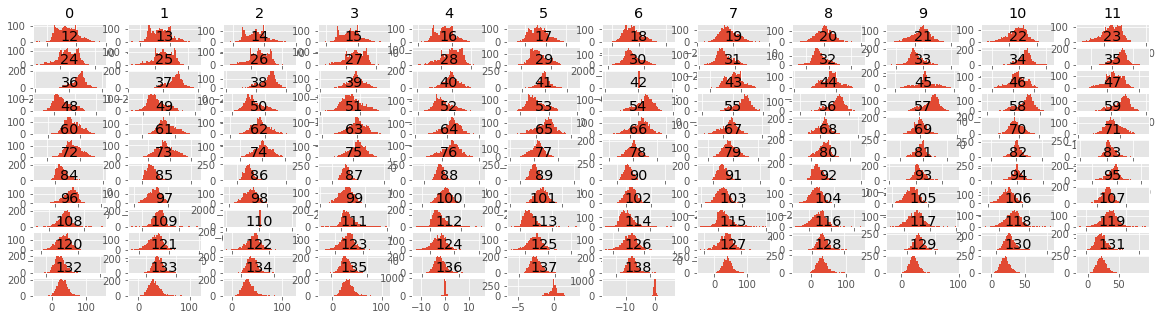

In [24]:
raw_data.hist(bins = 50, figsize = (20, 5))

> ### 3.2.1. Yaw and Roll Features

In [25]:
y_shift = 68

In [26]:
yaw_roll_5LM = ["8", "30", "36", "45", "48", "54", str(8 + y_shift), str(30+ y_shift), str(36+ y_shift), str(45+ y_shift), str(48+ y_shift), str(54+ y_shift)]

> ### 3.2.2. Pitch Features

In [27]:
pitch_12LM =["8", "1", "15", "36", "33", "45", "48", "54", "51", "27", "39", "42", str(8 + y_shift), str(1+ y_shift), str(15+ y_shift), str(36+ y_shift), str(33+ y_shift), str(45+ y_shift), str(48+ y_shift), str(54+ y_shift), str(51+ y_shift), str(27 + y_shift), str(39+ y_shift), str(42+ y_shift)]

> ###  Selected Landmarks 
- 5 landmarks for Yaw and Roll
- 12 landmark for Pitch

In [28]:
X_pitch = raw_data[pitch_12LM]

In [29]:
X_yaw = raw_data[yaw_roll_5LM]

In [30]:
X_roll = raw_data[yaw_roll_5LM]

> ### Labels

In [31]:
#pitch, yaw, roll
p = raw_data[["136"]].to_numpy()
y = raw_data[["137"]].to_numpy()
r = raw_data[["138"]].to_numpy()

> ## 3.3. Data Cleaning
- Removing outliers using IQR
- Normalization [0, 1]

> ### 3.3.1. Pitch

In [32]:
X_pitch.insert(loc= 0, column="pitch", value=p)


In [33]:
X_pitch.describe()

,pitch,8,1,15,36,33,45,48,54,51,...,83,104,101,113,116,122,119,95,107,110
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-0.107145,4.529596,-145.729522,150.934112,-58.620762,0.071158,57.772513,-25.027213,26.101726,0.270087,...,-36.239895,-54.783447,3.128822,-57.142489,33.126408,32.887755,14.379490,-33.303449,-41.484591,-41.938333
std,0.628119,56.088391,161.509997,160.851970,43.796796,3.338125,43.245190,26.718850,27.269610,6.457106,...,72.295852,30.228667,1.783441,30.440114,16.471247,16.238376,5.078080,10.317403,18.255384,17.892117
min,-12.457202,-194.634918,-638.594984,-413.216339,-183.654010,-11.746335,-143.268066,-136.300781,-70.079521,-25.957811,...,-379.331696,-159.508102,-2.797895,-164.334595,-52.149799,-46.732491,-5.897078,-79.503601,-117.544724,-115.068100
25%,-0.258503,-32.913113,-278.858643,41.131392,-90.458080,-1.625442,32.172476,-43.134400,8.810854,-3.913411,...,-73.684294,-74.421043,1.846700,-76.071817,22.373884,22.210968,10.899348,-39.616748,-52.896417,-52.856490
50%,-0.122268,4.212631,-150.646797,163.707657,-66.892551,0.097189,67.781937,-28.380521,29.716473,0.299956,...,-29.517064,-52.939074,2.907539,-54.491348,31.919427,31.613417,14.126781,-32.631998,-40.771446,-40.670824
75%,0.040192,41.340690,-26.933035,284.343216,-30.745308,1.831420,87.460556,-7.125732,44.309800,4.413188,...,1.504870,-34.565340,4.106041,-36.685059,42.237361,42.641796,17.256263,-26.883495,-29.532209,-30.961471
max,15.598820,250.905136,443.536865,677.723511,133.536621,10.544164,186.848282,69.122849,115.748909,21.444387,...,294.788696,131.862579,17.492509,125.213768,152.095271,154.862999,56.216815,32.838634,51.562538,61.933189


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc211a364d0>,
      dtype=object)

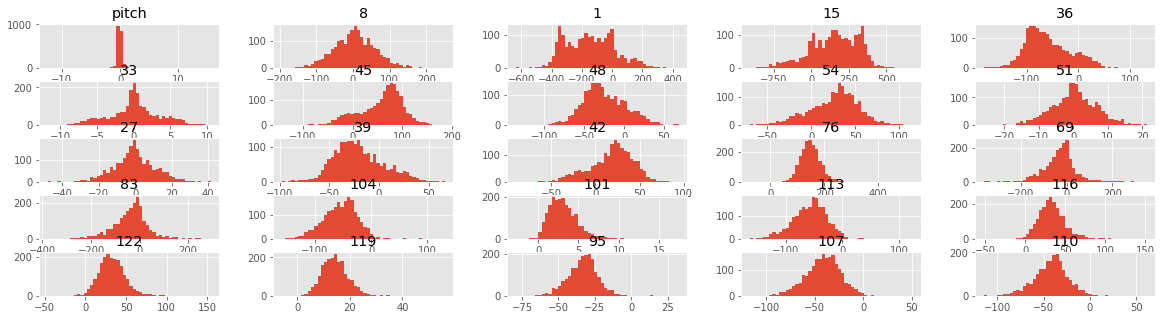

In [34]:
X_pitch.hist(bins = 50, figsize = (20, 5))

In [35]:
X_pitch = remove_Angle_outlier(X_pitch, "pitch")

In [36]:
X_pitch.describe()

,pitch,8,1,15,36,33,45,48,54,51,...,83,104,101,113,116,122,119,95,107,110
count,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000,...,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000
mean,-0.107809,5.019520,-152.174373,158.728694,-62.107830,0.087252,61.233324,-26.429130,27.781949,0.303520,...,-40.020690,-56.538614,2.996804,-59.227415,32.754451,32.407008,14.360993,-34.096807,-42.519266,-43.020904
std,0.221186,53.653628,149.579783,147.094070,41.109357,3.056708,40.370850,25.341096,25.667151,6.176409,...,67.353052,29.840431,1.618815,29.533485,15.911495,15.863752,4.987159,9.877162,17.861515,17.288737
min,-0.702382,-194.634918,-638.594984,-279.565552,-183.654010,-11.746335,-143.268066,-136.300781,-51.043179,-25.957811,...,-332.758484,-159.508102,-0.996384,-164.334595,-19.218119,-46.732491,-4.137651,-79.503601,-117.544724,-115.068100
25%,-0.246453,-31.552078,-273.960876,52.231026,-91.711670,-1.369417,36.730618,-43.610035,10.786819,-3.604189,...,-74.402168,-76.254753,1.803130,-77.753685,21.981199,21.737156,10.902452,-40.316338,-53.547211,-53.419617
50%,-0.125086,4.382998,-150.502502,164.107391,-69.020164,0.098508,69.578064,-28.868151,30.642017,0.300028,...,-31.033512,-54.628098,2.834660,-57.159603,31.556684,31.215704,14.066924,-33.258797,-41.492451,-41.638954
75%,0.019885,40.827892,-35.230614,279.503632,-35.058315,1.633510,88.666359,-9.010510,45.052734,4.069427,...,-1.708774,-36.027309,3.964868,-38.926971,41.664688,42.074318,17.214485,-27.681112,-30.433212,-31.862093
max,0.486662,250.905136,253.508972,677.723511,50.855518,10.544164,186.848282,46.432190,115.748909,21.444387,...,294.788696,131.862579,17.492509,63.464260,152.095271,154.862999,56.216815,6.602787,51.562538,17.262995


In [37]:
X_pitch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1841 entries, 0 to 1999
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pitch   1841 non-null   float64
 1   8       1841 non-null   float64
 2   1       1841 non-null   float64
 3   15      1841 non-null   float64
 4   36      1841 non-null   float64
 5   33      1841 non-null   float64
 6   45      1841 non-null   float64
 7   48      1841 non-null   float64
 8   54      1841 non-null   float64
 9   51      1841 non-null   float64
 10  27      1841 non-null   float64
 11  39      1841 non-null   float64
 12  42      1841 non-null   float64
 13  76      1841 non-null   float64
 14  69      1841 non-null   float64
 15  83      1841 non-null   float64
 16  104     1841 non-null   float64
 17  101     1841 non-null   float64
 18  113     1841 non-null   float64
 19  116     1841 non-null   float64
 20  122     1841 non-null   float64
 21  119     1841 non-null   float64
 22  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc20db66c50>,
      dtype=object)

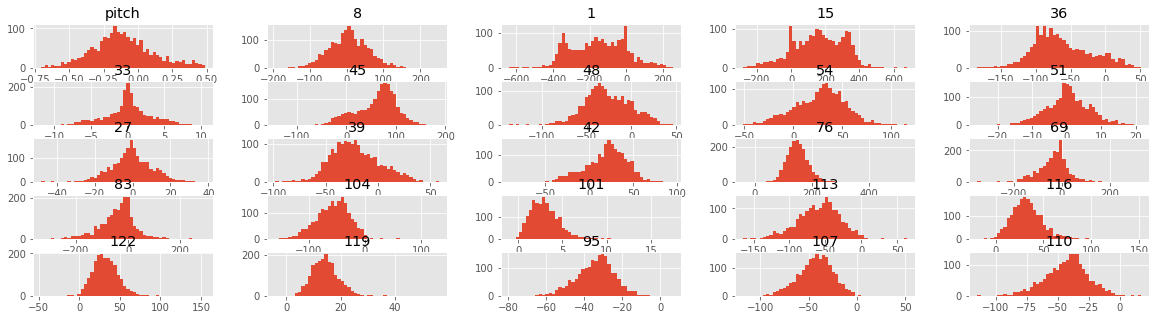

In [38]:
X_pitch.hist(bins = 50, figsize = (20, 5))

In [39]:
X_pitch = remove_outlier(X_pitch, X_pitch.columns)

In [40]:
X_pitch.describe()

,pitch,8,1,15,36,33,45,48,54,51,...,83,104,101,113,116,122,119,95,107,110
count,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,...,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000
mean,-0.105351,4.886292,-152.886984,156.861953,-62.065324,0.073183,60.559197,-26.540217,27.645558,0.284675,...,-38.894534,-56.055210,3.015437,-58.631412,32.961535,32.443654,14.375651,-33.855977,-42.126610,-42.575374
std,0.218529,52.989579,150.006975,146.661929,40.988181,3.056814,40.198139,25.403817,25.521260,6.121959,...,63.410215,29.453684,1.611866,27.975544,15.903028,15.746726,4.994229,9.430801,17.335198,16.264449
min,-0.702382,-194.634918,-638.594984,-279.565552,-183.654010,-11.746335,-143.268066,-136.300781,-51.043179,-25.957811,...,-298.706635,-159.508102,-0.996384,-150.026917,-19.218119,-46.732491,-4.137651,-62.074074,-94.281723,-85.639481
25%,-0.243464,-31.606566,-275.591187,50.213184,-91.452049,-1.392060,36.130688,-43.706842,10.675404,-3.614863,...,-72.626205,-75.723259,1.834170,-77.131611,22.497678,21.913924,10.935391,-40.086092,-53.240065,-53.164028
50%,-0.123677,4.195283,-150.502502,161.146027,-69.005157,0.097081,68.952263,-28.920822,30.566162,0.279817,...,-30.382467,-54.347137,2.849994,-56.661812,31.830299,31.307566,14.107421,-33.122410,-41.363354,-41.417442
75%,0.019961,40.535467,-36.301353,276.739075,-35.094503,1.626461,87.975689,-9.035691,45.016144,4.027479,...,-1.668039,-35.905046,3.974837,-38.868778,41.879478,42.130077,17.215394,-27.672812,-30.395627,-31.846459
max,0.486662,250.905136,253.508972,605.936829,50.855518,9.373781,186.848282,46.432190,103.020767,19.463554,...,205.712341,131.862579,17.492509,29.623421,152.095271,154.862999,56.216815,6.602787,51.562538,-0.486808


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2093a5a50>,
      dtype=object)

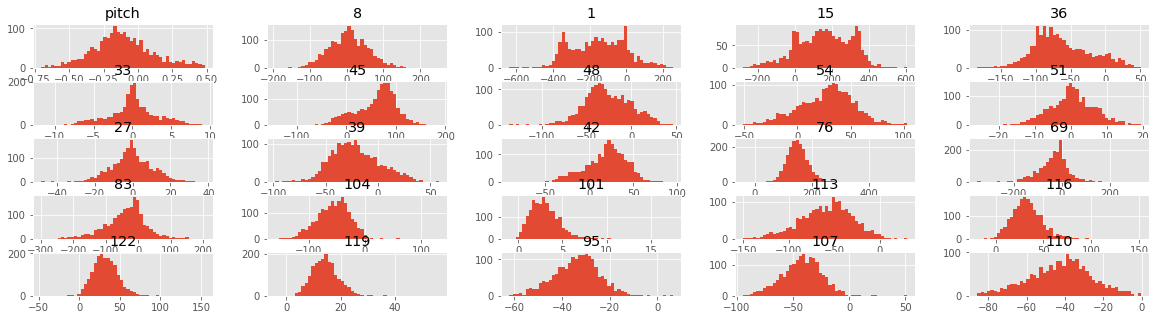

In [42]:
X_pitch.hist(bins = 50, figsize = (20, 5))

In [43]:
X_pitch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1815 entries, 0 to 1999
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pitch   1815 non-null   float64
 1   8       1815 non-null   float64
 2   1       1815 non-null   float64
 3   15      1815 non-null   float64
 4   36      1815 non-null   float64
 5   33      1815 non-null   float64
 6   45      1815 non-null   float64
 7   48      1815 non-null   float64
 8   54      1815 non-null   float64
 9   51      1815 non-null   float64
 10  27      1815 non-null   float64
 11  39      1815 non-null   float64
 12  42      1815 non-null   float64
 13  76      1815 non-null   float64
 14  69      1815 non-null   float64
 15  83      1815 non-null   float64
 16  104     1815 non-null   float64
 17  101     1815 non-null   float64
 18  113     1815 non-null   float64
 19  116     1815 non-null   float64
 20  122     1815 non-null   float64
 21  119     1815 non-null   float64
 22  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc207df5d50>,
      dtype=object)

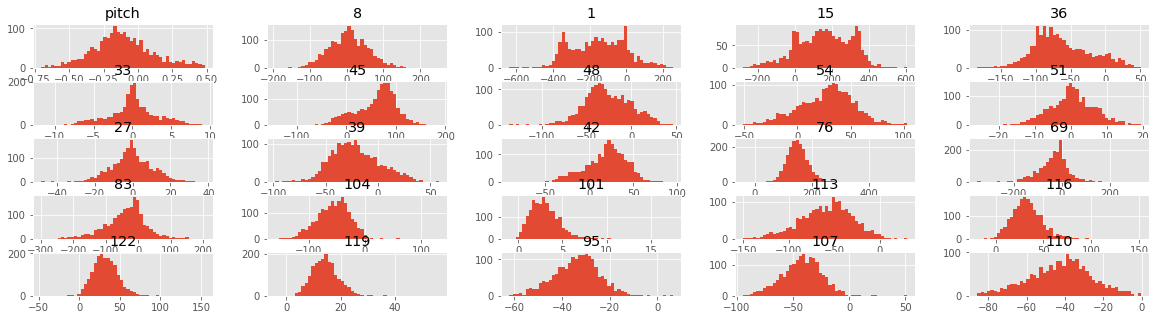

In [44]:
X_pitch.hist(bins = 50, figsize = (20, 5))

In [45]:
X_pitch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1815 entries, 0 to 1999
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pitch   1815 non-null   float64
 1   8       1815 non-null   float64
 2   1       1815 non-null   float64
 3   15      1815 non-null   float64
 4   36      1815 non-null   float64
 5   33      1815 non-null   float64
 6   45      1815 non-null   float64
 7   48      1815 non-null   float64
 8   54      1815 non-null   float64
 9   51      1815 non-null   float64
 10  27      1815 non-null   float64
 11  39      1815 non-null   float64
 12  42      1815 non-null   float64
 13  76      1815 non-null   float64
 14  69      1815 non-null   float64
 15  83      1815 non-null   float64
 16  104     1815 non-null   float64
 17  101     1815 non-null   float64
 18  113     1815 non-null   float64
 19  116     1815 non-null   float64
 20  122     1815 non-null   float64
 21  119     1815 non-null   float64
 22  

In [46]:
p = X_pitch["pitch"]
p

0      -0.399231
1       0.470065
2      -0.184650
3      -0.175379
5      -0.026812
          ...   
1994   -0.156035
1995   -0.197102
1996   -0.232617
1998   -0.420465
1999   -0.015552
Name: pitch, Length: 1815, dtype: float64

In [47]:
X_pitch.drop('pitch', axis = 1, inplace = True)

In [48]:
X_pitch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1815 entries, 0 to 1999
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   8       1815 non-null   float64
 1   1       1815 non-null   float64
 2   15      1815 non-null   float64
 3   36      1815 non-null   float64
 4   33      1815 non-null   float64
 5   45      1815 non-null   float64
 6   48      1815 non-null   float64
 7   54      1815 non-null   float64
 8   51      1815 non-null   float64
 9   27      1815 non-null   float64
 10  39      1815 non-null   float64
 11  42      1815 non-null   float64
 12  76      1815 non-null   float64
 13  69      1815 non-null   float64
 14  83      1815 non-null   float64
 15  104     1815 non-null   float64
 16  101     1815 non-null   float64
 17  113     1815 non-null   float64
 18  116     1815 non-null   float64
 19  122     1815 non-null   float64
 20  119     1815 non-null   float64
 21  95      1815 non-null   float64
 22  

> #### Normalization [0, 1]

In [60]:
X_pitch.min()

8     -194.634918
1     -638.594984
15    -279.565552
36    -183.654010
33     -11.746335
45    -143.268066
48    -136.300781
54     -51.043179
51     -25.957811
27     -48.235504
39     -98.102348
42     -90.383171
76     -40.908096
69    -351.330231
83    -298.706635
104   -159.508102
101     -0.996384
113   -150.026917
116    -19.218119
122    -46.732491
119     -4.137651
95     -62.074074
107    -94.281723
110    -85.639481
dtype: float64

In [63]:
 LM_pitch = X_pitch.min().to_list()
 Xmin_pitch = LM_pitch[:12]
 Ymin_pitch = LM_pitch[12:]

In [64]:
X_pitch.max()

8      250.905136
1      253.508972
15     605.936829
36      50.855518
33       9.373781
45     186.848282
48      46.432190
54     103.020767
51      19.463554
27      38.176659
39      58.384651
42      94.822937
76     531.066570
69     328.824768
83     205.712341
104    131.862579
101     17.492509
113     29.623421
116    152.095271
122    154.862999
119     56.216815
95       6.602787
107     51.562538
110     -0.486808
dtype: float64

In [65]:
 LM_pitch = X_pitch.max().to_list()
 Xmax_pitch = LM_pitch[:12]
 Ymax_pitch = LM_pitch[12:]

In [66]:
X_pitch = (X_pitch - X_pitch.min())/ (X_pitch.max() - X_pitch.min())

In [67]:
X_pitch.describe()

,8,1,15,36,33,45,48,54,51,27,...,83,104,101,113,116,122,119,95,107,110
count,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,...,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000
mean,0.447819,0.544452,0.492859,0.518481,0.559633,0.617441,0.600661,0.510754,0.577756,0.551286,...,0.515072,0.355056,0.216985,0.508741,0.304586,0.392748,0.306743,0.410882,0.357608,0.505728
std,0.118933,0.168150,0.165626,0.174783,0.144735,0.121770,0.139022,0.165654,0.134781,0.123923,...,0.125709,0.101087,0.087180,0.155722,0.092830,0.078111,0.082748,0.137321,0.118861,0.191003
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.365912,0.406908,0.372420,0.393169,0.490257,0.543441,0.506717,0.400604,0.491904,0.478440,...,0.448200,0.287554,0.153095,0.405762,0.243506,0.340516,0.249742,0.320166,0.281407,0.381379
50%,0.446268,0.547125,0.497697,0.488888,0.560765,0.642865,0.587633,0.529711,0.577649,0.550038,...,0.531947,0.360918,0.208037,0.519705,0.297983,0.387112,0.302299,0.421564,0.362842,0.519326
75%,0.527832,0.675138,0.628236,0.633490,0.633178,0.700492,0.696454,0.623503,0.660158,0.630778,...,0.588873,0.424212,0.268876,0.618747,0.356642,0.440796,0.353794,0.500915,0.438043,0.631724
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [68]:
X_pitch.index[np.isnan(X_pitch).any(1)]

Int64Index([], dtype='int64')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2041b02d0>,
      dtype=object)

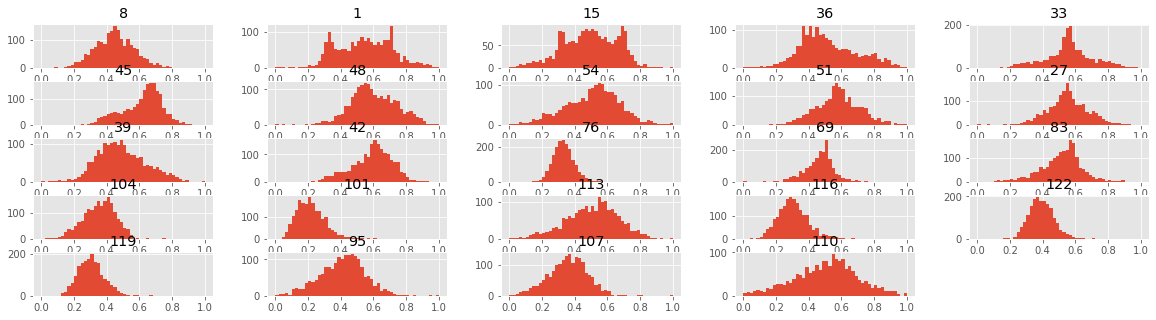

In [69]:
X_pitch.hist(bins = 50, figsize = (20, 5))

> ### 3.3.2. Yaw

In [70]:
X_yaw.insert(loc= 0, column="yaw", value=y)


In [71]:
X_yaw.describe()

,yaw,8,30,36,45,48,54,76,98,104,113,116,122
count,2000.000000,2000.000000,2000.0,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.014077,4.529596,0.0,-58.620762,57.772513,-25.027213,26.101726,148.429218,0.0,-54.783447,-57.142489,33.126408,32.887755
std,0.654185,56.088391,0.0,43.796796,43.245190,26.718850,27.269610,38.351464,0.0,30.228667,30.440114,16.471247,16.238376
min,-6.130066,-194.634918,0.0,-183.654010,-143.268066,-136.300781,-70.079521,-78.116943,0.0,-159.508102,-164.334595,-52.149799,-46.732491
25%,-0.294246,-32.913113,0.0,-90.458080,32.172476,-43.134400,8.810854,123.918070,0.0,-74.421043,-76.071817,22.373884,22.210968
50%,0.019702,4.212631,0.0,-66.892551,67.781937,-28.380521,29.716473,147.421288,0.0,-52.939074,-54.491348,31.919427,31.613417
75%,0.334715,41.340690,0.0,-30.745308,87.460556,-7.125732,44.309800,171.451241,0.0,-34.565340,-36.685059,42.237361,42.641796
max,3.277500,250.905136,0.0,133.536621,186.848282,69.122849,115.748909,531.066570,0.0,131.862579,125.213768,152.095271,154.862999


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc202eeae50>,
      dtype=object)

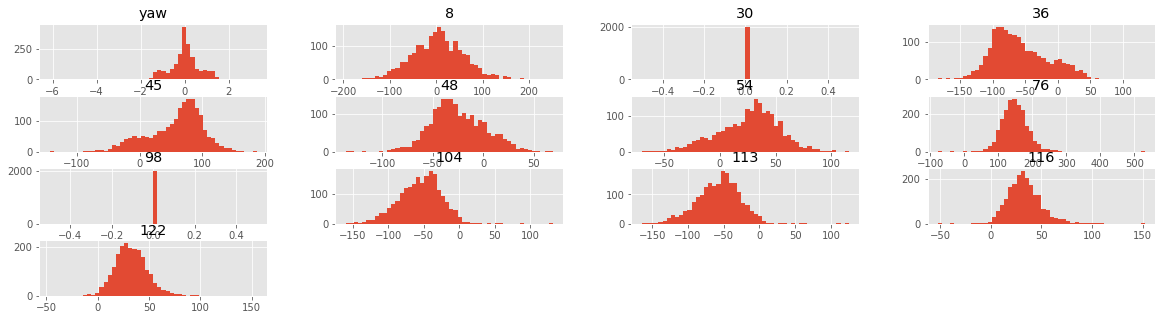

In [72]:
X_yaw.hist(bins = 50, figsize = (20, 5))

In [73]:
X_yaw = remove_Angle_outlier(X_yaw, "yaw")

In [74]:
X_yaw.describe()

,yaw,8,30,36,45,48,54,76,98,104,113,116,122
count,1865.000000,1865.000000,1865.0,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.0,1865.000000,1865.000000,1865.000000,1865.000000
mean,0.029141,5.539896,0.0,-61.791663,61.705286,-26.328601,28.183167,148.553107,0.0,-55.729898,-58.538755,33.097957,32.703323
std,0.543480,54.614720,0.0,41.387244,39.948954,25.641251,25.328362,38.621959,0.0,30.807764,30.379454,16.620909,16.590092
min,-1.233292,-194.634918,0.0,-183.654010,-143.268066,-136.300781,-56.398777,-40.908096,0.0,-159.508102,-164.334595,-19.218119,-46.732491
25%,-0.248667,-29.504923,0.0,-92.214645,36.514832,-43.763416,11.183369,123.319122,0.0,-76.368118,-77.753685,21.745159,21.508127
50%,0.022864,4.972103,0.0,-68.695297,70.138351,-28.702234,30.494982,147.417252,0.0,-54.396561,-56.823727,31.722229,31.338140
75%,0.314110,40.154133,0.0,-33.806686,88.918472,-8.733972,45.275585,171.715591,0.0,-34.976280,-37.947281,42.473331,42.833942
max,1.276055,250.905136,0.0,61.430481,186.848282,65.533508,115.748909,531.066570,0.0,131.862579,63.464260,152.095271,154.862999


In [75]:
X_yaw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1865 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yaw     1865 non-null   float64
 1   8       1865 non-null   float64
 2   30      1865 non-null   float64
 3   36      1865 non-null   float64
 4   45      1865 non-null   float64
 5   48      1865 non-null   float64
 6   54      1865 non-null   float64
 7   76      1865 non-null   float64
 8   98      1865 non-null   float64
 9   104     1865 non-null   float64
 10  113     1865 non-null   float64
 11  116     1865 non-null   float64
 12  122     1865 non-null   float64
dtypes: float64(13)
memory usage: 204.0 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc201f23fd0>,
      dtype=object)

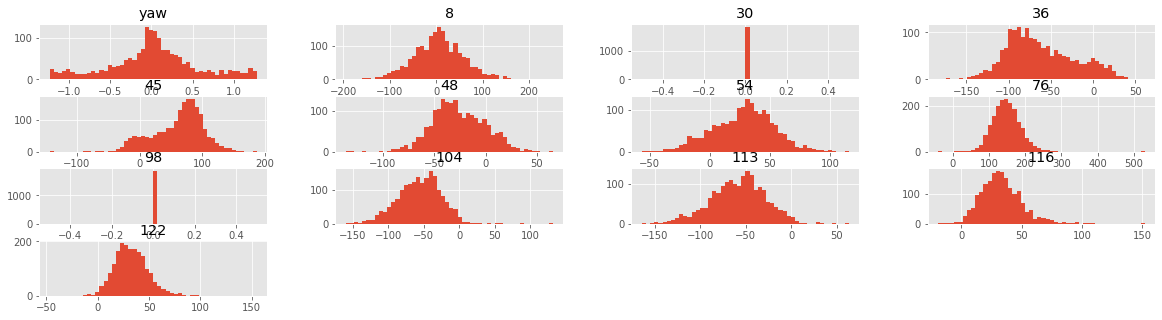

In [76]:
X_yaw.hist(bins = 50, figsize = (20, 5))

In [77]:
X_yaw = remove_outlier(X_yaw, X_yaw.columns)

In [78]:
X_yaw.describe()

,yaw,8,30,36,45,48,54,76,98,104,113,116,122
count,1833.000000,1833.000000,1833.0,1833.000000,1833.000000,1833.000000,1833.000000,1833.000000,1833.0,1833.000000,1833.000000,1833.000000,1833.000000
mean,0.030159,5.885664,0.0,-61.827211,61.682694,-26.098982,28.116279,147.376055,0.0,-56.285047,-59.192762,32.615338,31.997992
std,0.545254,53.992516,0.0,41.185739,39.427613,25.366318,25.250610,35.877796,0.0,30.311723,29.727951,15.908162,14.979714
min,-1.233292,-194.634918,0.0,-179.079529,-143.268066,-136.300781,-56.398777,5.828537,0.0,-159.508102,-164.334595,-19.218119,-10.380432
25%,-0.250969,-28.866404,0.0,-92.214645,36.734634,-43.610035,11.150228,123.014313,0.0,-76.483543,-78.129578,21.493521,21.464287
50%,0.022864,5.106119,0.0,-68.890297,70.138351,-28.489475,30.471016,146.876404,0.0,-54.718307,-57.312317,31.535645,31.127892
75%,0.317961,40.276314,0.0,-34.003193,88.796242,-8.432364,45.235905,170.953705,0.0,-35.227112,-38.834808,41.863499,42.325375
max,1.276055,250.905136,0.0,61.430481,162.805283,65.533508,115.748909,271.105713,0.0,131.862579,63.464260,108.396553,74.616661


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc201b1f590>,
      dtype=object)

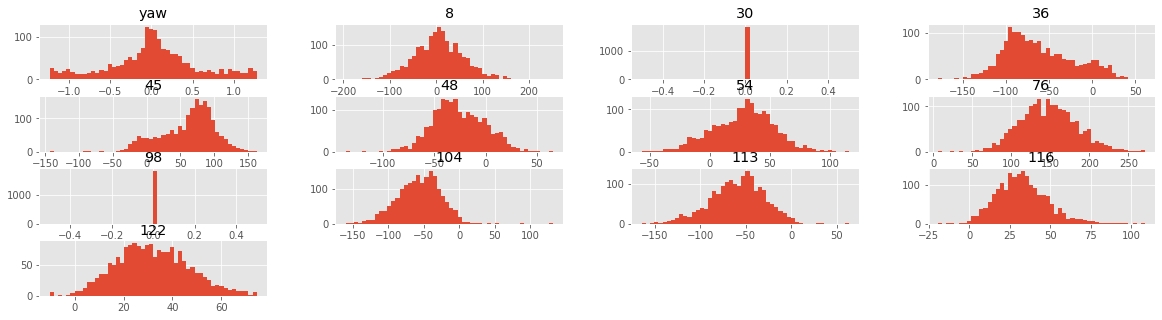

In [79]:
X_yaw.hist(bins = 50, figsize = (20, 5))

In [80]:
X_yaw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1833 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yaw     1833 non-null   float64
 1   8       1833 non-null   float64
 2   30      1833 non-null   float64
 3   36      1833 non-null   float64
 4   45      1833 non-null   float64
 5   48      1833 non-null   float64
 6   54      1833 non-null   float64
 7   76      1833 non-null   float64
 8   98      1833 non-null   float64
 9   104     1833 non-null   float64
 10  113     1833 non-null   float64
 11  116     1833 non-null   float64
 12  122     1833 non-null   float64
dtypes: float64(13)
memory usage: 200.5 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc20142a610>,
      dtype=object)

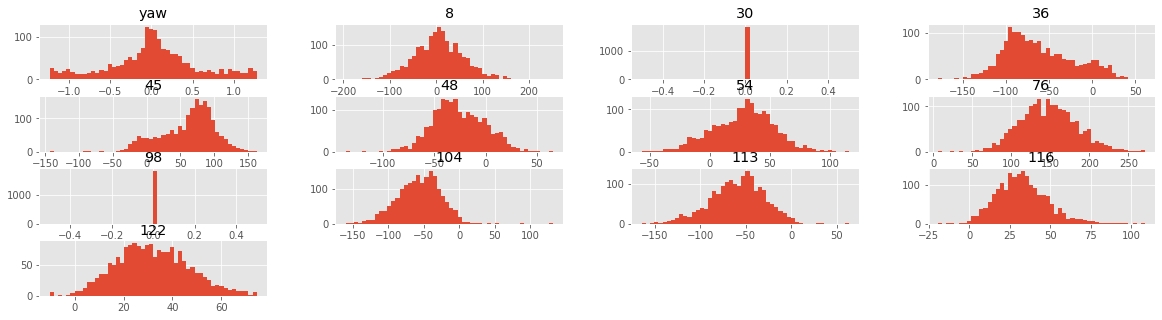

In [81]:
X_yaw.hist(bins = 50, figsize = (20, 5))

In [82]:
X_yaw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1833 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yaw     1833 non-null   float64
 1   8       1833 non-null   float64
 2   30      1833 non-null   float64
 3   36      1833 non-null   float64
 4   45      1833 non-null   float64
 5   48      1833 non-null   float64
 6   54      1833 non-null   float64
 7   76      1833 non-null   float64
 8   98      1833 non-null   float64
 9   104     1833 non-null   float64
 10  113     1833 non-null   float64
 11  116     1833 non-null   float64
 12  122     1833 non-null   float64
dtypes: float64(13)
memory usage: 200.5 KB


In [83]:
y = X_yaw["yaw"]
y

0       0.018227
1       1.189533
2       0.881137
3       0.299208
4       1.198004
          ...   
1993   -0.485061
1994    0.567114
1995   -0.070430
1998   -1.191176
1999   -0.180126
Name: yaw, Length: 1833, dtype: float64

In [84]:
X_yaw.drop('yaw', axis = 1, inplace = True)

In [85]:
X_yaw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1833 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   8       1833 non-null   float64
 1   30      1833 non-null   float64
 2   36      1833 non-null   float64
 3   45      1833 non-null   float64
 4   48      1833 non-null   float64
 5   54      1833 non-null   float64
 6   76      1833 non-null   float64
 7   98      1833 non-null   float64
 8   104     1833 non-null   float64
 9   113     1833 non-null   float64
 10  116     1833 non-null   float64
 11  122     1833 non-null   float64
dtypes: float64(12)
memory usage: 186.2 KB


>> ### Normalization [0, 1]

In [88]:
X_yaw.drop(['30', '98'], axis = 1, inplace = True)

In [89]:
 X_yaw.min()

8     -194.634918
36    -179.079529
45    -143.268066
48    -136.300781
54     -56.398777
76       5.828537
104   -159.508102
113   -164.334595
116    -19.218119
122    -10.380432
dtype: float64

In [92]:
 LM_yaw = X_yaw.min().to_list()
 Xmin_yaw = LM_yaw[:5]
 Ymin_yaw = LM_yaw[5:]

In [93]:
X_yaw.max()

8      250.905136
36      61.430481
45     162.805283
48      65.533508
54     115.748909
76     271.105713
104    131.862579
113     63.464260
116    108.396553
122     74.616661
dtype: float64

In [94]:
 LM_yaw = X_yaw.max().to_list()
 Xmax_yaw = LM_yaw[:5]
 Ymax_yaw = LM_yaw[5:]

In [95]:
X_yaw = (X_yaw - X_yaw.min())/ (X_yaw.max() - X_yaw.min())

In [96]:
X_yaw.describe()

,8,36,45,48,54,76,104,113,116,122
count,1833.000000,1833.000000,1833.000000,1833.000000,1833.000000,1833.000000,1833.000000,1833.000000,1833.000000,1833.000000
mean,0.450062,0.487515,0.669613,0.546001,0.490945,0.533583,0.354267,0.461556,0.406172,0.498587
std,0.121184,0.171243,0.128818,0.125679,0.146680,0.135246,0.104031,0.130501,0.124658,0.176238
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.372062,0.361170,0.588103,0.459242,0.392390,0.441748,0.284945,0.378426,0.319020,0.374657
50%,0.448312,0.458148,0.697239,0.534158,0.504624,0.531700,0.359644,0.469810,0.397711,0.488350
75%,0.527251,0.603203,0.758198,0.633532,0.590392,0.622463,0.426539,0.550924,0.478641,0.620090
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2006ee190>,
      dtype=object)

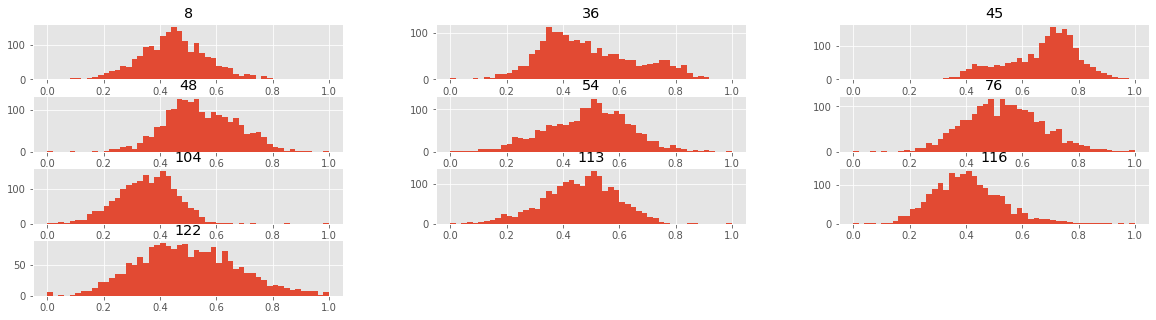

In [97]:
X_yaw.hist(bins = 50, figsize = (20, 5))

> ### 3.3.3. Roll

In [98]:
X_roll.insert(loc= 0, column="roll", value=r)

In [99]:
X_roll.describe()

,roll,8,30,36,45,48,54,76,98,104,113,116,122
count,2000.000000,2000.000000,2000.0,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.000000,2000.000000,2000.000000,2000.000000
mean,-0.034479,4.529596,0.0,-58.620762,57.772513,-25.027213,26.101726,148.429218,0.0,-54.783447,-57.142489,33.126408,32.887755
std,0.716014,56.088391,0.0,43.796796,43.245190,26.718850,27.269610,38.351464,0.0,30.228667,30.440114,16.471247,16.238376
min,-16.969362,-194.634918,0.0,-183.654010,-143.268066,-136.300781,-70.079521,-78.116943,0.0,-159.508102,-164.334595,-52.149799,-46.732491
25%,-0.174806,-32.913113,0.0,-90.458080,32.172476,-43.134400,8.810854,123.918070,0.0,-74.421043,-76.071817,22.373884,22.210968
50%,-0.018098,4.212631,0.0,-66.892551,67.781937,-28.380521,29.716473,147.421288,0.0,-52.939074,-54.491348,31.919427,31.613417
75%,0.134378,41.340690,0.0,-30.745308,87.460556,-7.125732,44.309800,171.451241,0.0,-34.565340,-36.685059,42.237361,42.641796
max,5.829394,250.905136,0.0,133.536621,186.848282,69.122849,115.748909,531.066570,0.0,131.862579,125.213768,152.095271,154.862999


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1ff6d9f90>,
      dtype=object)

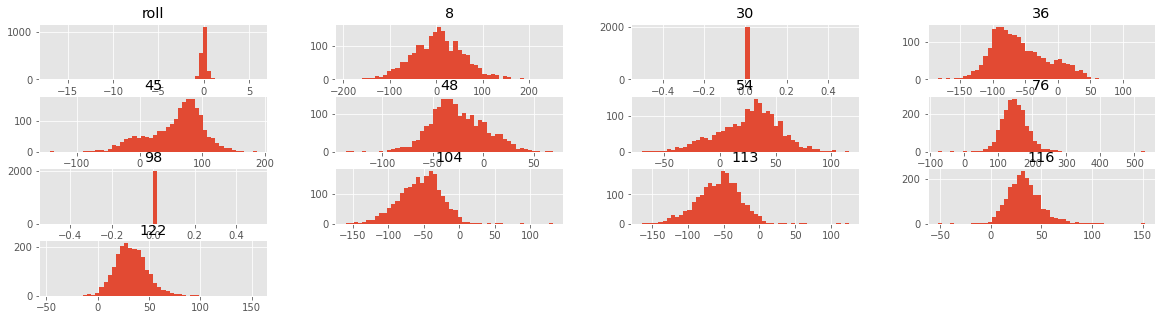

In [100]:
X_roll.hist(bins = 50, figsize = (20, 5))

In [101]:
X_roll = remove_Angle_outlier(X_roll, "roll")

In [102]:
X_roll.describe()

,roll,8,30,36,45,48,54,76,98,104,113,116,122
count,1815.000000,1815.000000,1815.0,1815.000000,1815.000000,1815.000000,1815.000000,1815.000000,1815.0,1815.000000,1815.000000,1815.000000,1815.000000
mean,-0.021801,4.941112,0.0,-62.332360,61.552937,-26.512328,27.996975,150.233202,0.0,-56.077409,-58.713326,33.477429,33.167043
std,0.236294,48.578098,0.0,41.102399,39.781148,24.775984,24.978946,37.050902,0.0,28.319763,28.615173,15.946611,15.693848
min,-0.636640,-152.439346,0.0,-183.654010,-56.122810,-136.300781,-51.043179,48.424305,0.0,-159.508102,-164.334595,-9.483962,-8.714865
25%,-0.155410,-29.477620,0.0,-92.264992,37.816103,-43.288143,11.413350,125.384762,0.0,-75.247128,-76.833733,22.832373,22.473163
50%,-0.019081,4.382998,0.0,-70.044708,70.256302,-28.890409,30.722237,148.385818,0.0,-54.082546,-56.189167,32.032803,31.816597
75%,0.110664,39.809551,0.0,-35.781502,88.392937,-9.523543,44.922100,172.170830,0.0,-35.909525,-38.775620,42.387693,42.626369
max,0.594136,186.068542,0.0,50.855518,186.848282,39.535946,115.748909,531.066570,0.0,24.273708,11.880994,152.095271,154.862999


In [103]:
X_roll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1815 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   roll    1815 non-null   float64
 1   8       1815 non-null   float64
 2   30      1815 non-null   float64
 3   36      1815 non-null   float64
 4   45      1815 non-null   float64
 5   48      1815 non-null   float64
 6   54      1815 non-null   float64
 7   76      1815 non-null   float64
 8   98      1815 non-null   float64
 9   104     1815 non-null   float64
 10  113     1815 non-null   float64
 11  116     1815 non-null   float64
 12  122     1815 non-null   float64
dtypes: float64(13)
memory usage: 198.5 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1fe945b10>,
      dtype=object)

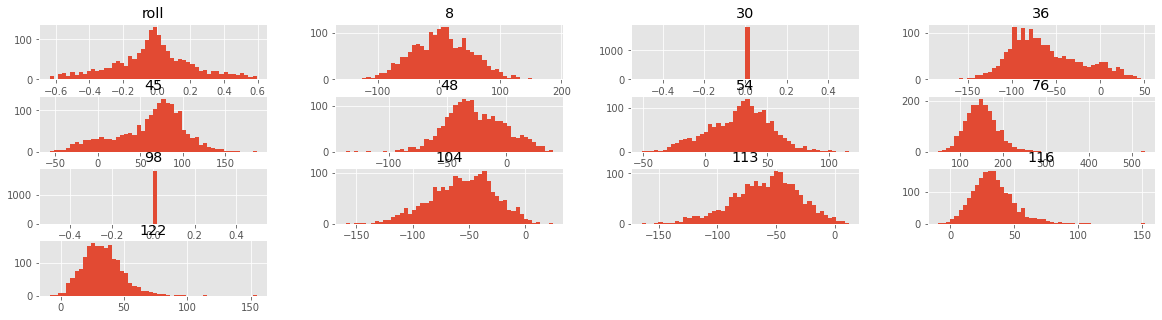

In [104]:
X_roll.hist(bins = 50, figsize = (20, 5))

In [105]:
X_roll = remove_outlier(X_roll, X_roll.columns)

In [106]:
X_roll.describe()

,roll,8,30,36,45,48,54,76,98,104,113,116,122
count,1784.000000,1784.000000,1784.0,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000,1784.0,1784.000000,1784.000000,1784.000000,1784.000000
mean,-0.023917,5.309876,0.0,-62.333558,61.375281,-26.197307,27.825043,148.720405,0.0,-56.498913,-59.383372,32.906592,32.330397
std,0.236215,48.538076,0.0,40.889809,39.583714,24.578344,24.872979,34.442074,0.0,28.154131,28.117267,15.035426,14.164264
min,-0.636640,-152.439346,0.0,-179.079529,-56.122810,-136.300781,-51.043179,48.424305,0.0,-159.508102,-164.334595,-9.483962,-2.896796
25%,-0.158654,-29.286665,0.0,-92.218182,37.838374,-42.916138,11.200907,125.111584,0.0,-75.416861,-77.129023,22.741663,22.360770
50%,-0.020590,4.548689,0.0,-70.204334,70.197327,-28.629550,30.637825,147.763557,0.0,-54.499298,-56.722733,31.861706,31.512777
75%,0.108213,39.991118,0.0,-35.790634,88.304956,-9.223234,44.596803,171.029758,0.0,-36.378245,-39.378079,41.817155,41.939182
max,0.594136,186.068542,0.0,48.913834,162.805283,39.535946,115.748909,271.105713,0.0,24.273708,9.135871,108.396553,72.027794


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1fd840990>,
      dtype=object)

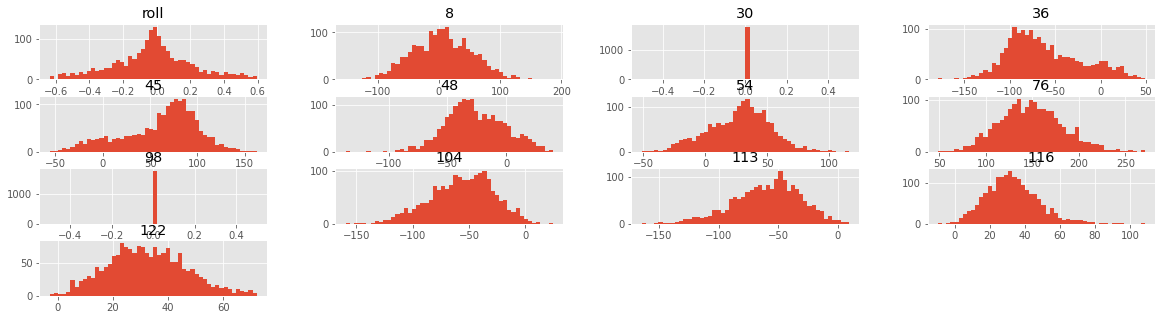

In [107]:
X_roll.hist(bins = 50, figsize = (20, 5))

In [108]:
X_roll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1784 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   roll    1784 non-null   float64
 1   8       1784 non-null   float64
 2   30      1784 non-null   float64
 3   36      1784 non-null   float64
 4   45      1784 non-null   float64
 5   48      1784 non-null   float64
 6   54      1784 non-null   float64
 7   76      1784 non-null   float64
 8   98      1784 non-null   float64
 9   104     1784 non-null   float64
 10  113     1784 non-null   float64
 11  116     1784 non-null   float64
 12  122     1784 non-null   float64
dtypes: float64(13)
memory usage: 195.1 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1fd4cff50>,
      dtype=object)

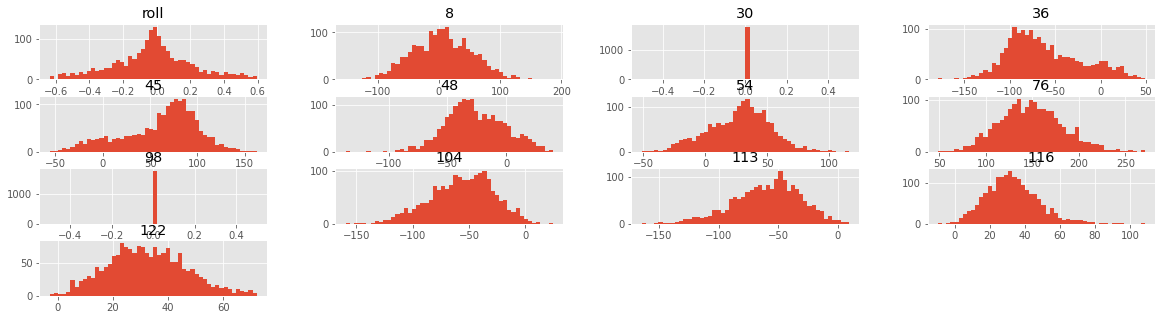

In [109]:
X_roll.hist(bins = 50, figsize = (20, 5))

In [110]:
X_roll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1784 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   roll    1784 non-null   float64
 1   8       1784 non-null   float64
 2   30      1784 non-null   float64
 3   36      1784 non-null   float64
 4   45      1784 non-null   float64
 5   48      1784 non-null   float64
 6   54      1784 non-null   float64
 7   76      1784 non-null   float64
 8   98      1784 non-null   float64
 9   104     1784 non-null   float64
 10  113     1784 non-null   float64
 11  116     1784 non-null   float64
 12  122     1784 non-null   float64
dtypes: float64(13)
memory usage: 195.1 KB


In [111]:
r = X_roll["roll"]
r

0       0.085676
1       0.300959
2      -0.236852
3      -0.373374
5      -0.220662
          ...   
1994   -0.108536
1995    0.105118
1996    0.175960
1998    0.451515
1999   -0.024546
Name: roll, Length: 1784, dtype: float64

In [112]:
X_roll.drop('roll', axis = 1, inplace = True)

In [113]:
X_roll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1784 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   8       1784 non-null   float64
 1   30      1784 non-null   float64
 2   36      1784 non-null   float64
 3   45      1784 non-null   float64
 4   48      1784 non-null   float64
 5   54      1784 non-null   float64
 6   76      1784 non-null   float64
 7   98      1784 non-null   float64
 8   104     1784 non-null   float64
 9   113     1784 non-null   float64
 10  116     1784 non-null   float64
 11  122     1784 non-null   float64
dtypes: float64(12)
memory usage: 181.2 KB


> #### Normalization [0, 1]

In [114]:
X_roll.drop(['30', '98'], axis = 1, inplace = True)

In [115]:
 X_roll.min()

8     -152.439346
36    -179.079529
45     -56.122810
48    -136.300781
54     -51.043179
76      48.424305
104   -159.508102
113   -164.334595
116     -9.483962
122     -2.896796
dtype: float64

In [116]:
 LM_roll = X_roll.min().to_list()
 Xmin_roll = LM_roll[:5]
 Ymin_roll = LM_roll[5:]

In [117]:
X_roll.max()

8      186.068542
36      48.913834
45     162.805283
48      39.535946
54     115.748909
76     271.105713
104     24.273708
113      9.135871
116    108.396553
122     72.027794
dtype: float64

In [118]:
 LM_roll = X_roll.max().to_list()
 Xmax_roll = LM_roll[:5]
 Ymax_roll = LM_roll[5:]

In [119]:
X_roll = (X_roll - X_roll.min())/ (X_roll.max() - X_roll.min())

In [120]:
X_roll.describe()

,8,36,45,48,54,76,104,113,116,122
count,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000
mean,0.466013,0.512059,0.536697,0.626169,0.472853,0.450402,0.560497,0.605009,0.359606,0.470169
std,0.143388,0.179346,0.180807,0.139779,0.149126,0.154670,0.153193,0.162087,0.127548,0.189047
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.363810,0.380982,0.429187,0.531087,0.373184,0.344381,0.457560,0.502711,0.273375,0.337106
50%,0.463765,0.477537,0.576994,0.612336,0.489717,0.446105,0.571378,0.620347,0.350742,0.459256
75%,0.568467,0.628478,0.659704,0.722702,0.573408,0.550587,0.669978,0.720333,0.435196,0.598415
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1fbf64c50>,
      dtype=object)

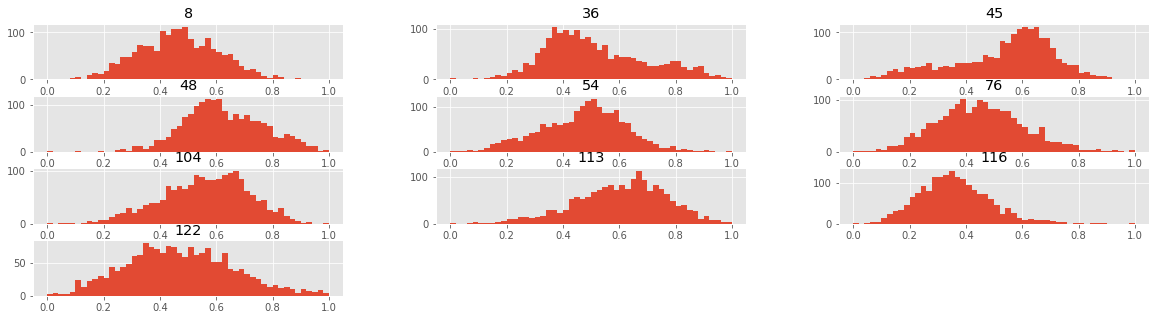

In [121]:
X_roll.hist(bins = 50, figsize = (20, 5))

<a name = "Model"></a>

# 4. Models

> ## 4.1. Pitch

In [123]:
features = X_pitch

In [124]:
labels = p

In [125]:
from sklearn.model_selection import train_test_split

In [126]:
# split data by 60% train ; use random_state=100
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(features, labels, test_size = 0.4, random_state=100)

In [127]:
# split test data by 50% validation and 50% test ; use random_state=100
features_validation, features_test, labels_validation, labels_test = train_test_split(features_validation_test, labels_validation_test, test_size = 0.5, random_state=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2044a6950>,
      dtype=object)

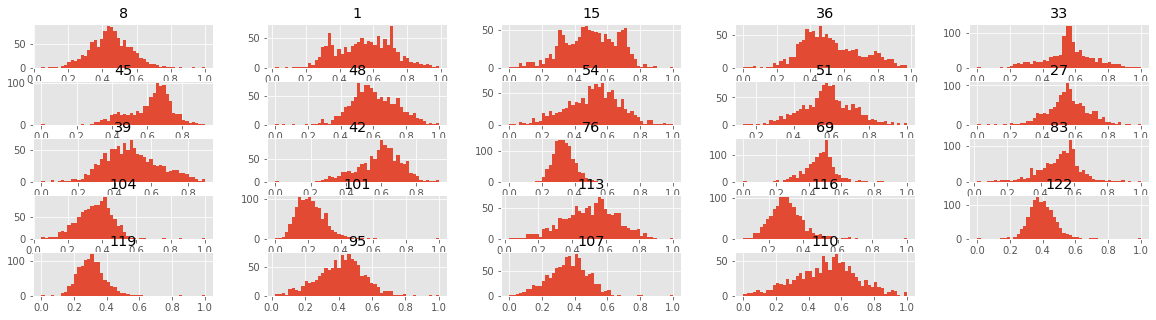

In [128]:
features_train.hist(bins = 50, figsize = (20, 5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1f9df9910>,
      dtype=object)

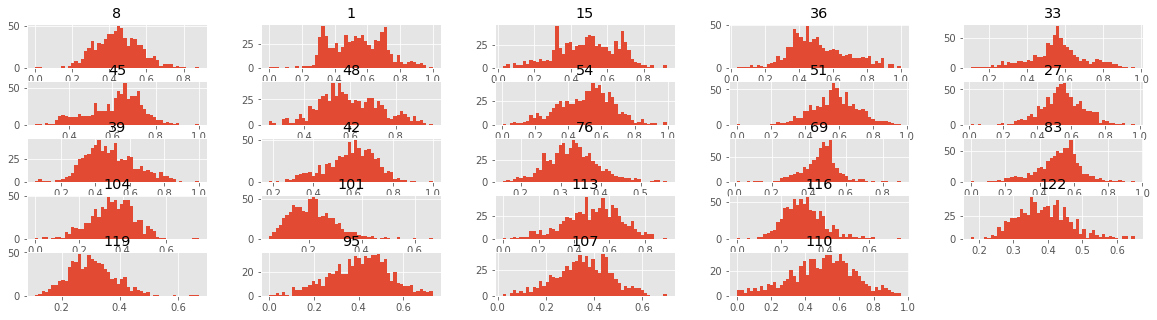

In [129]:
features_validation_test.hist(bins = 50, figsize = (20, 5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1f8843410>,
      dtype=object)

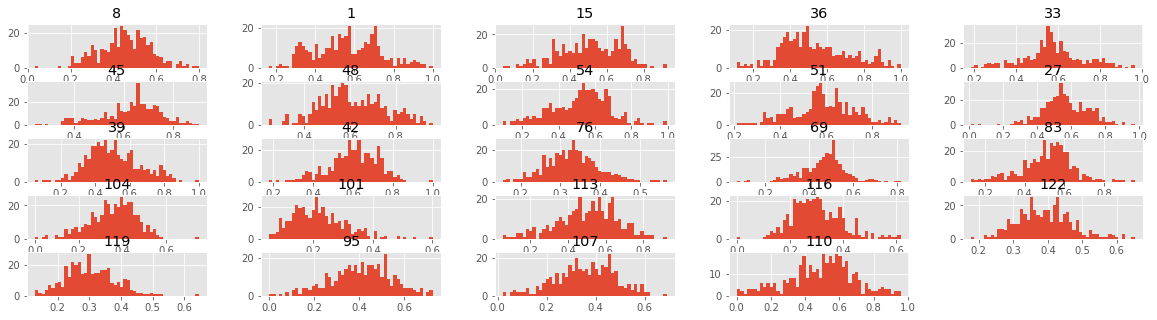

In [130]:
features_validation.hist(bins = 50, figsize = (20, 5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1f72c5c90>,
      dtype=object)

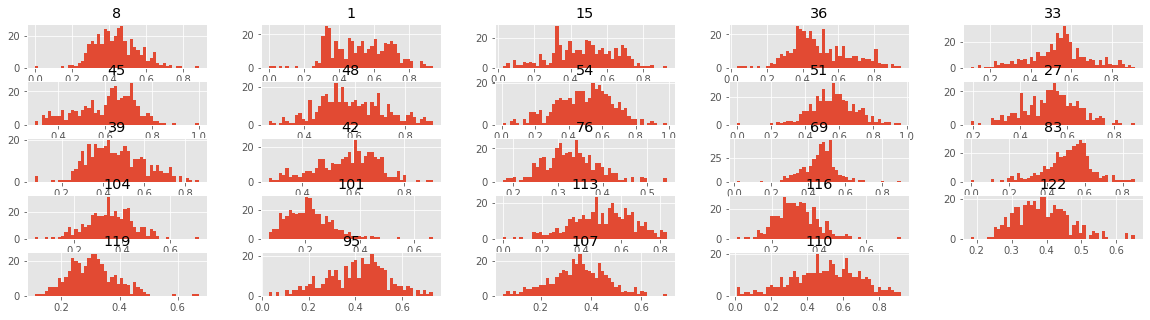

In [131]:
features_test.hist(bins = 50, figsize = (20, 5))

In [132]:
print(len(features_train))
print(len(features_validation))
print(len(features_test))
print(len(labels_train))
print(len(labels_validation))
print(len(labels_test))

1089
363
363
1089
363
363


> ### 4.1.1. Training different models on our dataset



We'll train six models:
- Linear Regression
- Decision tree Regressor
- Support vector Regression (SVR)
- RandomForestRegressor
- GradientBoostingRegressor
- AdaBoostRegressor

In [133]:
# Train linear regression model
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression().fit(features_train, labels_train)

In [134]:
# Train decision tree model ; don't use any hyperparameter
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor().fit(features_train, labels_train)

In [135]:
# Train SVM model ; don't use any hyperparameter
from sklearn.svm import SVR

svm_model = SVR().fit(features_train, labels_train)

In [136]:
# Train random forest model ; don't use any hyperparameter
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor().fit(features_train, labels_train)

In [137]:
# Train gradient boosting model ; don't use any hyperparameter
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor().fit(features_train, labels_train)

In [138]:
# Train Adaboost model ; don't use any hyperparameter
from sklearn.ensemble import AdaBoostRegressor

ab_model = AdaBoostRegressor().fit(features_train, labels_train)

In [139]:
# ************************************************* #
# ***************** SVR Specified ***************** #
# ************************************************* #

from sklearn.svm import SVR

svr_model_linear = SVR(kernel='linear').fit(features_train, labels_train)
svr_model_poly = SVR(kernel='poly').fit(features_train, labels_train)           # default = 3
# svr_model_poly4 = SVR(kernel='poly', degree=4).fit(features_train, labels_train)
# svr_model_poly5 = SVR(kernel='poly', degree=5).fit(features_train, labels_train)
svr_model_rbf = SVR(kernel='rbf').fit(features_train, labels_train)
svr_model_sigmoid = SVR(kernel='sigmoid').fit(features_train, labels_train)
#svr_model_precomputed = SVR(kernel='precomputed').fit(features_train, labels_train)

> ### 4.1.2. Evaluating the models Validation Accuracy

In [140]:
# ************************************************* #
# ***************** SVR Specified ***************** #
# ************************************************* #

print("SVR_L:", svr_model_linear.score(features_validation,labels_validation))
print("SVR_P:", svr_model_poly.score(features_validation,labels_validation))
# print("SVR_P4:", svr_model_poly4.score(features_validation,labels_validation))
# print("SVR_P5:", svr_model_poly5.score(features_validation,labels_validation))
print("SVR_rbf:", svr_model_rbf.score(features_validation,labels_validation))
print("SVR_sigmoid:", svr_model_sigmoid.score(features_validation,labels_validation))
#print("SVR_pre:", svr_model_precomputed.score(features_validation,labels_validation))

SVR_L: 0.8108489885787301
SVR_P: 0.8897942186284815
SVR_rbf: 0.9196024963726355
SVR_sigmoid: -0.04883775176068661


In [141]:
# print R2-score of each model on validation data

from sklearn.metrics import r2_score

print("R2-scores of the models:")
labels_predict = lr_model.predict(features_validation)
print("Linear regression:", r2_score(labels_validation, labels_predict))
labels_predict = dt_model.predict(features_validation)
print("Decision tree:", r2_score(labels_validation, labels_predict))
labels_predict = svm_model.predict(features_validation)
print("SVR:", r2_score(labels_validation, labels_predict))
labels_predict = rf_model.predict(features_validation)
print("Random forest:", r2_score(labels_validation, labels_predict))
labels_predict = gb_model.predict(features_validation)
print("Gradient boosting:", r2_score(labels_validation, labels_predict))
labels_predict = ab_model.predict(features_validation)
print("AdaBoost:", r2_score(labels_validation, labels_predict))

R2-scores of the models:
Linear regression: 0.8484725939056582
Decision tree: 0.8175500960117692
SVR: 0.9196024963726355
Random forest: 0.9155911746653793
Gradient boosting: 0.9234735175300491
AdaBoost: 0.8208912462303819


In [142]:
# ************************************************* #
# ************** Evaluations Metrics ************** #
# ************************************************* #

print("Scores of the models:")
labels_predict = lr_model.predict(features_validation)
print("Linear regression:")
evaluate_model(labels_validation, labels_predict)
labels_predict = dt_model.predict(features_validation)
print("Decision tree:")
evaluate_model(labels_validation, labels_predict)
labels_predict = svm_model.predict(features_validation)
print("SVR:")
evaluate_model(labels_validation, labels_predict)
labels_predict = rf_model.predict(features_validation)
print("Random forest:")
evaluate_model(labels_validation, labels_predict)
labels_predict = gb_model.predict(features_validation)
print("Gradient boosting:")
evaluate_model(labels_validation, labels_predict)
labels_predict = ab_model.predict(features_validation)
print("AdaBoost:")
evaluate_model(labels_validation, labels_predict)

Scores of the models:
Linear regression:
Mean Absolute Error (MAE): 0.06043149325087331
Mean Squared Error (MSE): 0.007859723741059399
Root Mean Squared Error (RMSE): 0.08865508299617907
Mean Absolute Percentage Error (MAPE): 0.47463941907912977
Explained Variance Score: 0.8489511163845674
Max Error: 0.39302273884318456
Median Absolute Error: 0.04001840859009864
R^2: 0.8484725939056582
 
*****************************************************************
 
Decision tree:
Mean Absolute Error (MAE): 0.06579150605695523
Mean Squared Error (MSE): 0.009463673132749902
Root Mean Squared Error (RMSE): 0.09728141206186258
Mean Absolute Percentage Error (MAPE): 0.6171288150646357
Explained Variance Score: 0.8181804403214703
Max Error: 0.4658822435885668
Median Absolute Error: 0.0446577202528714
R^2: 0.8175500960117692
 
*****************************************************************
 
SVR:
Mean Absolute Error (MAE): 0.045725374666287004
Mean Squared Error (MSE): 0.0041702170205994305
Root Mean 

> ### 4.1.3. Evaluating the models Testing Accuracy

In [143]:
# ************************************************* #
# ***************** SVR Specified ***************** #
# ************************************************* #

print("SVR_L:", svr_model_linear.score(features_test,labels_test))
print("SVR_P:", svr_model_poly.score(features_test,labels_test))
# print("SVR_P4:", svr_model_poly4.score(features_test,labels_test))
# print("SVR_P5:", svr_model_poly5.score(features_test,labels_test))
print("SVR_rbf:", svr_model_rbf.score(features_test,labels_test))
print("SVR_sigmoid:", svr_model_sigmoid.score(features_test,labels_test))

SVR_L: 0.8116614474876502
SVR_P: 0.9184322579591502
SVR_rbf: 0.9109957955389104
SVR_sigmoid: -0.05733417427565479


In [144]:
# print R2-score of each model on testing data

print("Scores of the models")
print("Linear regression:", lr_model.score(features_test,labels_test))
print("Decision tree:", dt_model.score(features_test,labels_test))
print("SVR:", svm_model.score(features_test,labels_test))
print("Random forest:", rf_model.score(features_test,labels_test))
print("Gradient boosting:", gb_model.score(features_test,labels_test))
print("AdaBoost:", ab_model.score(features_test,labels_test))

Scores of the models
Linear regression: 0.8247695737961379
Decision tree: 0.7261823695302841
SVR: 0.9109957955389104
Random forest: 0.8758285809726359
Gradient boosting: 0.8981956592819603
AdaBoost: 0.7653396518584572


In [145]:
# ************************************************* #
# ************** Evaluations Metrics ************** #
# ************************************************* #

print("Scores of the models:")
labels_predict = lr_model.predict(features_test)
print("Linear regression:")
evaluate_model(labels_test, labels_predict)
labels_predict = dt_model.predict(features_test)
print("Decision tree:")
evaluate_model(labels_test, labels_predict)
labels_predict = svm_model.predict(features_test)
print("SVR:")
evaluate_model(labels_test, labels_predict)
labels_predict = rf_model.predict(features_test)
print("Random forest:")
evaluate_model(labels_test, labels_predict)
labels_predict = gb_model.predict(features_test)
print("Gradient boosting:")
evaluate_model(labels_test, labels_predict)
labels_predict = ab_model.predict(features_test)
print("AdaBoost:")
evaluate_model(labels_test, labels_predict)

Scores of the models:
Linear regression:
Mean Absolute Error (MAE): 0.05977086295560165
Mean Squared Error (MSE): 0.008528755325270983
Root Mean Squared Error (RMSE): 0.09235126055052514
Mean Absolute Percentage Error (MAPE): 1.0630113638847414
Explained Variance Score: 0.8247850958866333
Max Error: 0.45632138120922383
Median Absolute Error: 0.03788225656884553
R^2: 0.8247695737961379
 
*****************************************************************
 
Decision tree:
Mean Absolute Error (MAE): 0.07180958910393204
Mean Squared Error (MSE): 0.013327157986277843
Root Mean Squared Error (RMSE): 0.11544331070390282
Mean Absolute Percentage Error (MAPE): 1.012327660535809
Explained Variance Score: 0.7269998709131208
Max Error: 0.6827296912670135
Median Absolute Error: 0.04588237404823309
R^2: 0.7261823695302841
 
*****************************************************************
 
SVR:
Mean Absolute Error (MAE): 0.04458290350317613
Mean Squared Error (MSE): 0.004331982174636144
Root Mean Squ

> ### 4.1.4. Grid Search SVR

In [146]:
from sklearn.model_selection import GridSearchCV

In [147]:
svm_parameters = {'kernel': ['rbf', 'linear'],
                  'C': [0.00001, 0.0005, 0.0001, 0.005, 0.001, 0.01, 0.1, 1 , 10, 50 ,100],
                  'gamma': [0.00001, 0.0005, 0.0001, 0.005, 0.001, 0.01, 0.1, 1 , 10, 50 ,100]
                }
# use gridsearch to find the best hyperparameters 
svm = SVR()
svm_gs = GridSearchCV(estimator = svm, param_grid = svm_parameters)

svm_gs.fit(features_train, np.ravel(labels_train))
# git the best model 
svm_winner = svm_gs.best_estimator_
svm_winner

svm_winner.score(features_validation, labels_validation)

0.9055533650797305

In [148]:
svm_winner

SVR(C=50, gamma=0.1)

In [149]:
svm_winner.score(features_test, labels_test)

0.9005269700403961

> ### 4.1.5. Save the Model

In [150]:
# use joblib to save the model
import joblib

In [151]:
joblib.dump(svm_winner, model_path + "svm_model_pitch_92.12.pkl")

['drive/My Drive/AI-Pro Track ITI/ML1/Project/Models/svm_model_pitch_92.12.pkl']

In [152]:
p_svm_model = svm_winner
#p_svm_model = joblib.load("svm_model_pitch_92.12.pkl")


> ## 4.2. Yaw

In [153]:
features = X_yaw

In [154]:
labels = y

In [155]:
from sklearn.model_selection import train_test_split

In [156]:
# split data by 60% train ; use random_state=100
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(features, labels, test_size = 0.4, random_state=100)

In [157]:
# split test data by 50% validation and 50% test ; use random_state=100
features_validation, features_test, labels_validation, labels_test = train_test_split(features_validation_test, labels_validation_test, test_size = 0.5, random_state=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1f453b1d0>,
      dtype=object)

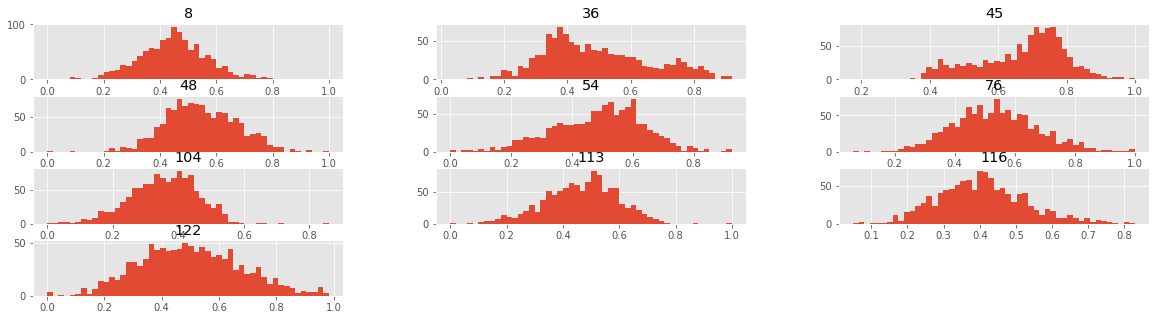

In [158]:
features_train.hist(bins = 50, figsize = (20, 5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1f3b4eed0>,
      dtype=object)

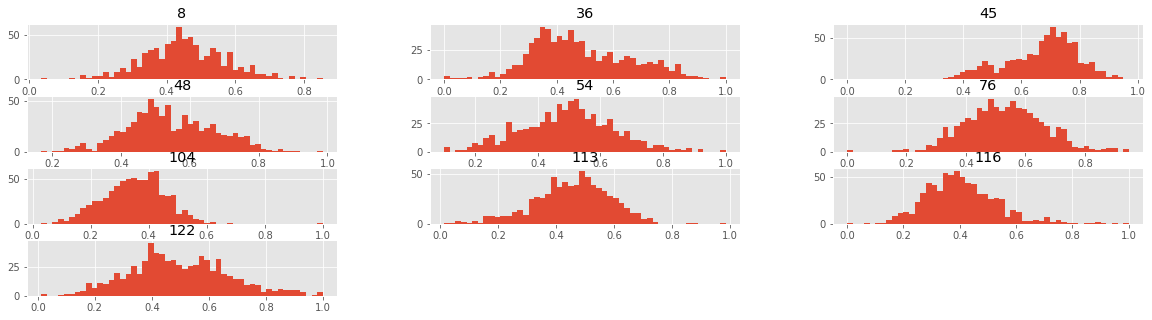

In [159]:
features_validation_test.hist(bins = 50, figsize = (20, 5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1f3b0ba50>,
      dtype=object)

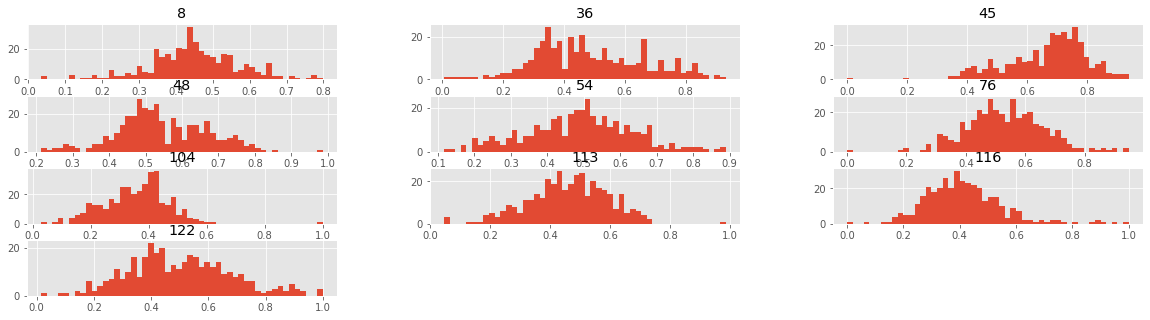

In [160]:
features_validation.hist(bins = 50, figsize = (20, 5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1f28c0b90>,
      dtype=object)

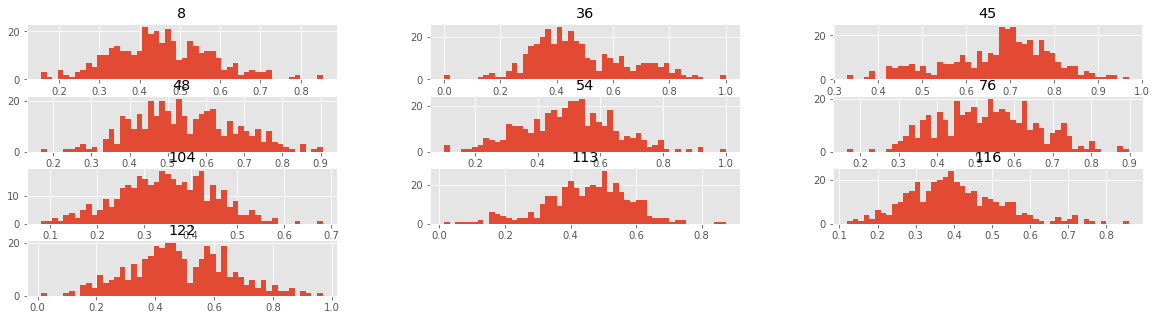

In [161]:
features_test.hist(bins = 50, figsize = (20, 5))

In [162]:
print(len(features_train))
print(len(features_validation))
print(len(features_test))
print(len(labels_train))
print(len(labels_validation))
print(len(labels_test))

1099
367
367
1099
367
367


> ### 4.2.1. Training different models on our dataset



We'll train six models:
- Linear Regression
- Decision tree Regressor
- Support vector Regression (SVR)
- RandomForestRegressor
- GradientBoostingRegressor
- AdaBoostRegressor

In [163]:
# Train linear regression model
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression().fit(features_train, labels_train)

In [164]:
# Train decision tree model ; don't use any hyperparameter
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor().fit(features_train, labels_train)

In [165]:
# Train SVM model ; don't use any hyperparameter
from sklearn.svm import SVR

svm_model = SVR().fit(features_train, labels_train)

In [166]:
# Train random forest model ; don't use any hyperparameter
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor().fit(features_train, labels_train)

In [167]:
# Train gradient boosting model ; don't use any hyperparameter
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor().fit(features_train, labels_train)

In [168]:
# Train Adaboost model ; don't use any hyperparameter
from sklearn.ensemble import AdaBoostRegressor

ab_model = AdaBoostRegressor().fit(features_train, labels_train)

In [169]:
# ************************************************* #
# ***************** SVR Specified ***************** #
# ************************************************* #

from sklearn.svm import SVR

svr_model_linear = SVR(kernel='linear').fit(features_train, labels_train)
svr_model_poly = SVR(kernel='poly').fit(features_train, labels_train)           # default = 3
# svr_model_poly4 = SVR(kernel='poly', degree=4).fit(features_train, labels_train)
# svr_model_poly5 = SVR(kernel='poly', degree=5).fit(features_train, labels_train)
svr_model_rbf = SVR(kernel='rbf').fit(features_train, labels_train)
svr_model_sigmoid = SVR(kernel='sigmoid').fit(features_train, labels_train)
#svr_model_precomputed = SVR(kernel='precomputed').fit(features_train, labels_train)

> ### 4.2.2. Evaluating the models Validation Accuracy

In [170]:
# ************************************************* #
# ***************** SVR Specified ***************** #
# ************************************************* #

print("SVR_L:", svr_model_linear.score(features_validation,labels_validation))
print("SVR_P:", svr_model_poly.score(features_validation,labels_validation))
# print("SVR_P4:", svr_model_poly4.score(features_validation,labels_validation))
# print("SVR_P5:", svr_model_poly5.score(features_validation,labels_validation))
print("SVR_rbf:", svr_model_rbf.score(features_validation,labels_validation))
print("SVR_sigmoid:", svr_model_sigmoid.score(features_validation,labels_validation))
#print("SVR_pre:", svr_model_precomputed.score(features_validation,labels_validation))

SVR_L: 0.8835414984107697
SVR_P: 0.9624144244686358
SVR_rbf: 0.9776962298629068
SVR_sigmoid: -0.006729239985018509


In [171]:
# print R2-score of each model on validation data

from sklearn.metrics import r2_score

print("R2-scores of the models:")
labels_predict = lr_model.predict(features_validation)
print("Linear regression:", r2_score(labels_validation, labels_predict))
labels_predict = dt_model.predict(features_validation)
print("Decision tree:", r2_score(labels_validation, labels_predict))
labels_predict = svm_model.predict(features_validation)
print("SVR:", r2_score(labels_validation, labels_predict))
labels_predict = rf_model.predict(features_validation)
print("Random forest:", r2_score(labels_validation, labels_predict))
labels_predict = gb_model.predict(features_validation)
print("Gradient boosting:", r2_score(labels_validation, labels_predict))
labels_predict = ab_model.predict(features_validation)
print("AdaBoost:", r2_score(labels_validation, labels_predict))

R2-scores of the models:
Linear regression: 0.8814177410837722
Decision tree: 0.9809254749293345
SVR: 0.9776962298629068
Random forest: 0.993024561115636
Gradient boosting: 0.9917595330865403
AdaBoost: 0.9751614960332916


In [172]:
# ************************************************* #
# ************** Evaluations Metrics ************** #
# ************************************************* #

print("Scores of the models:")
labels_predict = lr_model.predict(features_validation)
print("Linear regression:")
evaluate_model(labels_validation, labels_predict)
labels_predict = dt_model.predict(features_validation)
print("Decision tree:")
evaluate_model(labels_validation, labels_predict)
labels_predict = svm_model.predict(features_validation)
print("SVR:")
evaluate_model(labels_validation, labels_predict)
labels_predict = rf_model.predict(features_validation)
print("Random forest:")
evaluate_model(labels_validation, labels_predict)
labels_predict = gb_model.predict(features_validation)
print("Gradient boosting:")
evaluate_model(labels_validation, labels_predict)
labels_predict = ab_model.predict(features_validation)
print("AdaBoost:")
evaluate_model(labels_validation, labels_predict)

Scores of the models:
Linear regression:
Mean Absolute Error (MAE): 0.13171279582732023
Mean Squared Error (MSE): 0.035500632406441524
Root Mean Squared Error (RMSE): 0.18841611503913758
Mean Absolute Percentage Error (MAPE): 1.0318635903496722
Explained Variance Score: 0.8817690338733755
Max Error: 1.4097154146367177
Median Absolute Error: 0.08868245668556046
R^2: 0.8814177410837722
 
*****************************************************************
 
Decision tree:
Mean Absolute Error (MAE): 0.057047545026320576
Mean Squared Error (MSE): 0.0057104469846499225
Root Mean Squared Error (RMSE): 0.07556749952625084
Mean Absolute Percentage Error (MAPE): 1.2865538679995665
Explained Variance Score: 0.9810197919139956
Max Error: 0.29640424251556396
Median Absolute Error: 0.04246783256530762
R^2: 0.9809254749293345
 
*****************************************************************
 
SVR:
Mean Absolute Error (MAE): 0.0495231690499066
Mean Squared Error (MSE): 0.006677204095716186
Root Mean S

> ### 4.2.3. Evaluating the models Testing Accuracy

In [173]:
# ************************************************* #
# ***************** SVR Specified ***************** #
# ************************************************* #

print("SVR_L:", svr_model_linear.score(features_test,labels_test))
print("SVR_P:", svr_model_poly.score(features_test,labels_test))
# print("SVR_P4:", svr_model_poly4.score(features_test,labels_test))
# print("SVR_P5:", svr_model_poly5.score(features_test,labels_test))
print("SVR_rbf:", svr_model_rbf.score(features_test,labels_test))
print("SVR_sigmoid:", svr_model_sigmoid.score(features_test,labels_test))

SVR_L: 0.9004018420701778
SVR_P: 0.9632732001666692
SVR_rbf: 0.9847110384423107
SVR_sigmoid: -0.005121870891600322


In [174]:
# print R2-score of each model on testing data

print("Scores of the models")
print("Linear regression:", lr_model.score(features_test,labels_test))
print("Decision tree:", dt_model.score(features_test,labels_test))
print("SVR:", svm_model.score(features_test,labels_test))
print("Random forest:", rf_model.score(features_test,labels_test))
print("Gradient boosting:", gb_model.score(features_test,labels_test))
print("AdaBoost:", ab_model.score(features_test,labels_test))

Scores of the models
Linear regression: 0.9032234575387009
Decision tree: 0.9834345499978672
SVR: 0.9847110384423107
Random forest: 0.9934546297007939
Gradient boosting: 0.9913048559536025
AdaBoost: 0.9777108734127138


In [175]:
# ************************************************* #
# ************** Evaluations Metrics ************** #
# ************************************************* #

print("Scores of the models:")
labels_predict = lr_model.predict(features_test)
print("Linear regression:")
evaluate_model(labels_test, labels_predict)
labels_predict = dt_model.predict(features_test)
print("Decision tree:")
evaluate_model(labels_test, labels_predict)
labels_predict = svm_model.predict(features_test)
print("SVR:")
evaluate_model(labels_test, labels_predict)
labels_predict = rf_model.predict(features_test)
print("Random forest:")
evaluate_model(labels_test, labels_predict)
labels_predict = gb_model.predict(features_test)
print("Gradient boosting:")
evaluate_model(labels_test, labels_predict)
labels_predict = ab_model.predict(features_test)
print("AdaBoost:")
evaluate_model(labels_test, labels_predict)

Scores of the models:
Linear regression:
Mean Absolute Error (MAE): 0.11822087004706851
Mean Squared Error (MSE): 0.02687233289684749
Root Mean Squared Error (RMSE): 0.163927828317365
Mean Absolute Percentage Error (MAPE): 0.8663164299515451
Explained Variance Score: 0.9037649192428276
Max Error: 0.6439392206864687
Median Absolute Error: 0.08434470349407253
R^2: 0.9032234575387009
 
*****************************************************************
 
Decision tree:
Mean Absolute Error (MAE): 0.05113731248447626
Mean Squared Error (MSE): 0.0045997953194227064
Root Mean Squared Error (RMSE): 0.06782179088923196
Mean Absolute Percentage Error (MAPE): 0.9161354089092163
Explained Variance Score: 0.9834399404807642
Max Error: 0.3205249309539795
Median Absolute Error: 0.03979587554931638
R^2: 0.9834345499978672
 
*****************************************************************
 
SVR:
Mean Absolute Error (MAE): 0.04606814679917277
Mean Squared Error (MSE): 0.004245347624292651
Root Mean Squar

> ### 4.2.4. Grid Search SVR

In [176]:
from sklearn.model_selection import GridSearchCV

In [177]:
svm_parameters = {'kernel': ['rbf', 'linear'],
                  'C': [0.00001, 0.0005, 0.0001, 0.005, 0.001, 0.01, 0.1, 1 , 10, 50 ,100],
                  'gamma': [0.00001, 0.0005, 0.0001, 0.005, 0.001, 0.01, 0.1, 1 , 10, 50 ,100]
                }
# use gridsearch to find the best hyperparameters 
svm = SVR()
svm_gs = GridSearchCV(estimator = svm, param_grid = svm_parameters)

svm_gs.fit(features_train, np.ravel(labels_train))
# git the best model 
svm_winner = svm_gs.best_estimator_
svm_winner

svm_winner.score(features_validation, labels_validation)

0.9860236530480755

In [178]:
svm_winner

SVR(C=50, gamma=1)

In [179]:
svm_winner.score(features_test, labels_test)

0.985869725107467

> ### 4.2.5. Save the Model

In [180]:
# use joblib to save the model
import joblib

In [181]:
joblib.dump(svm_winner, model_path + "svm_model_yaw_98.5.pkl")

['drive/My Drive/AI-Pro Track ITI/ML1/Project/Models/svm_model_yaw_98.5.pkl']

In [182]:
joblib.dump(rf_model, model_path + "rf_model_yaw_99.37.pkl")

['drive/My Drive/AI-Pro Track ITI/ML1/Project/Models/rf_model_yaw_99.37.pkl']

In [183]:
y_rf_model = rf_model

> ## 4.3. Roll

In [184]:
features = X_roll

In [185]:
labels = r

In [186]:
from sklearn.model_selection import train_test_split

In [187]:
# split data by 60% train ; use random_state=100
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(features, labels, test_size = 0.4, random_state=100)

In [188]:
# split test data by 50% validation and 50% test ; use random_state=100
features_validation, features_test, labels_validation, labels_test = train_test_split(features_validation_test, labels_validation_test, test_size = 0.5, random_state=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1f451c190>,
      dtype=object)

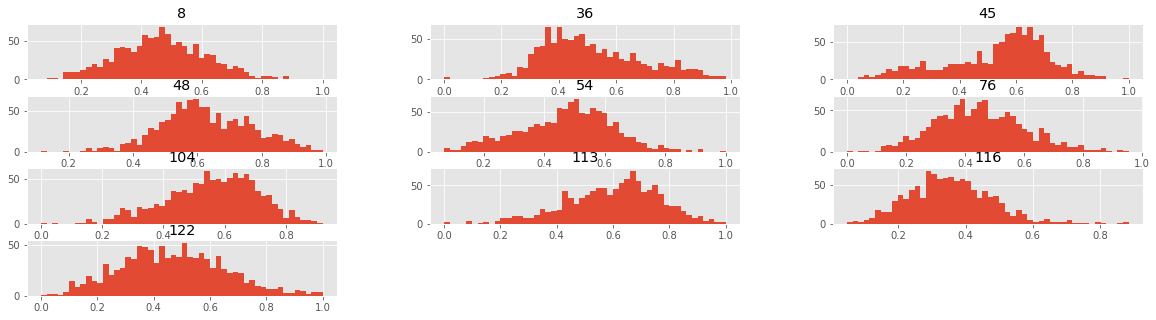

In [189]:
features_train.hist(bins = 50, figsize = (20, 5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1f1d52110>,
      dtype=object)

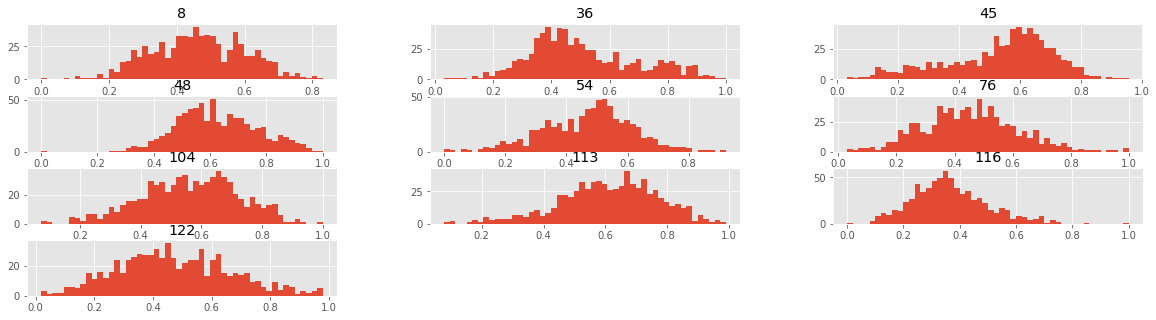

In [190]:
features_validation_test.hist(bins = 50, figsize = (20, 5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1f0edf750>,
      dtype=object)

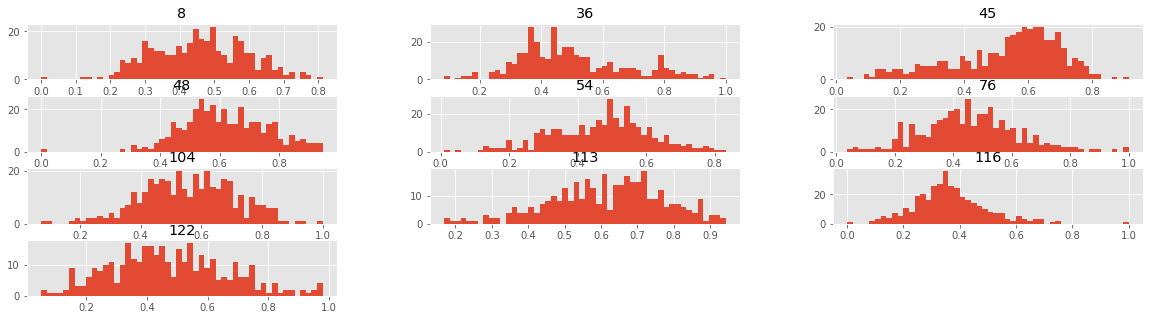

In [191]:
features_validation.hist(bins = 50, figsize = (20, 5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1f0476f90>,
      dtype=object)

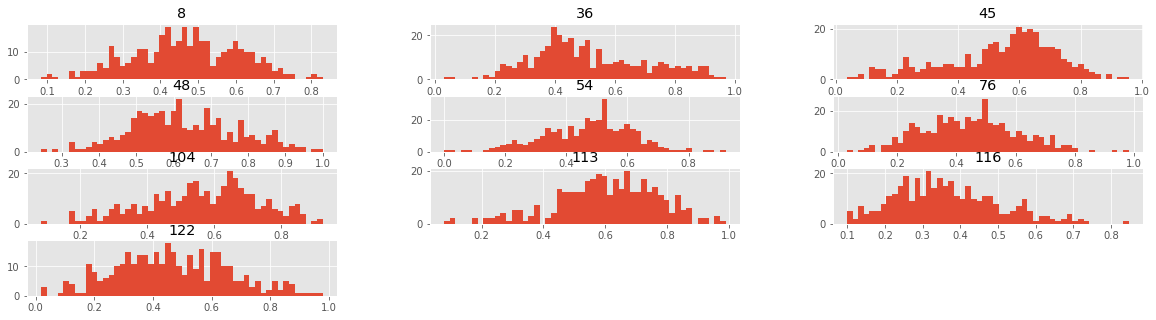

In [192]:
features_test.hist(bins = 50, figsize = (20, 5))

In [193]:
print(len(features_train))
print(len(features_validation))
print(len(features_test))
print(len(labels_train))
print(len(labels_validation))
print(len(labels_test))

1070
357
357
1070
357
357


> ### 4.3.1. Training different models on our dataset



We'll train six models:
- Linear Regression
- Decision tree Regressor
- Support vector Regression (SVR)
- RandomForestRegressor
- GradientBoostingRegressor
- AdaBoostRegressor

In [194]:
# Train linear regression model
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression().fit(features_train, labels_train)

In [195]:
# Train decision tree model ; don't use any hyperparameter
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor().fit(features_train, labels_train)

In [196]:
# Train SVM model ; don't use any hyperparameter
from sklearn.svm import SVR

svm_model = SVR().fit(features_train, labels_train)

In [197]:
# Train random forest model ; don't use any hyperparameter
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor().fit(features_train, labels_train)

In [198]:
# Train gradient boosting model ; don't use any hyperparameter
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor().fit(features_train, labels_train)

In [199]:
# Train Adaboost model ; don't use any hyperparameter
from sklearn.ensemble import AdaBoostRegressor

ab_model = AdaBoostRegressor().fit(features_train, labels_train)

In [200]:
# ************************************************* #
# ***************** SVR Specified ***************** #
# ************************************************* #

from sklearn.svm import SVR

svr_model_linear = SVR(kernel='linear').fit(features_train, labels_train)
svr_model_poly = SVR(kernel='poly').fit(features_train, labels_train)           # default = 3
# svr_model_poly4 = SVR(kernel='poly', degree=4).fit(features_train, labels_train)
# svr_model_poly5 = SVR(kernel='poly', degree=5).fit(features_train, labels_train)
svr_model_rbf = SVR(kernel='rbf').fit(features_train, labels_train)
svr_model_sigmoid = SVR(kernel='sigmoid').fit(features_train, labels_train)
#svr_model_precomputed = SVR(kernel='precomputed').fit(features_train, labels_train)

> ### 4.3.2. Evaluating the models Validation Accuracy

In [201]:
# ************************************************* #
# ***************** SVR Specified ***************** #
# ************************************************* #

print("SVR_L:", svr_model_linear.score(features_validation,labels_validation))
print("SVR_P:", svr_model_poly.score(features_validation,labels_validation))
# print("SVR_P4:", svr_model_poly4.score(features_validation,labels_validation))
# print("SVR_P5:", svr_model_poly5.score(features_validation,labels_validation))
print("SVR_rbf:", svr_model_rbf.score(features_validation,labels_validation))
print("SVR_sigmoid:", svr_model_sigmoid.score(features_validation,labels_validation))
#print("SVR_pre:", svr_model_precomputed.score(features_validation,labels_validation))

SVR_L: 0.7985882786287435
SVR_P: 0.8781813443116522
SVR_rbf: 0.9150258832002841
SVR_sigmoid: -0.014960590742198354


In [202]:
# print R2-score of each model on validation data

from sklearn.metrics import r2_score

print("R2-scores of the models:")
labels_predict = lr_model.predict(features_validation)
print("Linear regression:", r2_score(labels_validation, labels_predict))
labels_predict = dt_model.predict(features_validation)
print("Decision tree:", r2_score(labels_validation, labels_predict))
labels_predict = svm_model.predict(features_validation)
print("SVR:", r2_score(labels_validation, labels_predict))
labels_predict = rf_model.predict(features_validation)
print("Random forest:", r2_score(labels_validation, labels_predict))
labels_predict = gb_model.predict(features_validation)
print("Gradient boosting:", r2_score(labels_validation, labels_predict))
labels_predict = ab_model.predict(features_validation)
print("AdaBoost:", r2_score(labels_validation, labels_predict))

R2-scores of the models:
Linear regression: 0.804162405977502
Decision tree: 0.7102978815068424
SVR: 0.9150258832002841
Random forest: 0.9139739947516802
Gradient boosting: 0.9029042068388681
AdaBoost: 0.7538570389253471


In [203]:
# ************************************************* #
# ************** Evaluations Metrics ************** #
# ************************************************* #

print("Scores of the models:")
labels_predict = lr_model.predict(features_validation)
print("Linear regression:")
evaluate_model(labels_validation, labels_predict)
labels_predict = dt_model.predict(features_validation)
print("Decision tree:")
evaluate_model(labels_validation, labels_predict)
labels_predict = svm_model.predict(features_validation)
print("SVR:")
evaluate_model(labels_validation, labels_predict)
labels_predict = rf_model.predict(features_validation)
print("Random forest:")
evaluate_model(labels_validation, labels_predict)
labels_predict = gb_model.predict(features_validation)
print("Gradient boosting:")
evaluate_model(labels_validation, labels_predict)
labels_predict = ab_model.predict(features_validation)
print("AdaBoost:")
evaluate_model(labels_validation, labels_predict)

Scores of the models:
Linear regression:
Mean Absolute Error (MAE): 0.05814120529875203
Mean Squared Error (MSE): 0.00940557660484843
Root Mean Squared Error (RMSE): 0.09698235202782221
Mean Absolute Percentage Error (MAPE): 1.125131042774606
Explained Variance Score: 0.8082739455581172
Max Error: 0.5102514174891102
Median Absolute Error: 0.031118178844391886
R^2: 0.804162405977502
 
*****************************************************************
 
Decision tree:
Mean Absolute Error (MAE): 0.07568663605704057
Mean Squared Error (MSE): 0.013913648611110094
Root Mean Squared Error (RMSE): 0.11795613002769333
Mean Absolute Percentage Error (MAPE): 1.8184393013080344
Explained Variance Score: 0.7103555663147221
Max Error: 0.7219825237989425
Median Absolute Error: 0.0460945466766133
R^2: 0.7102978815068424
 
*****************************************************************
 
SVR:
Mean Absolute Error (MAE): 0.041136011314572465
Mean Squared Error (MSE): 0.004081088562072764
Root Mean Squar

> ### 4.3.3. Evaluating the models Testing Accuracy

In [204]:
# ************************************************* #
# ***************** SVR Specified ***************** #
# ************************************************* #

print("SVR_L:", svr_model_linear.score(features_test,labels_test))
print("SVR_P:", svr_model_poly.score(features_test,labels_test))
# print("SVR_P4:", svr_model_poly4.score(features_test,labels_test))
# print("SVR_P5:", svr_model_poly5.score(features_test,labels_test))
print("SVR_rbf:", svr_model_rbf.score(features_test,labels_test))
print("SVR_sigmoid:", svr_model_sigmoid.score(features_test,labels_test))

SVR_L: 0.8107118529463442
SVR_P: 0.9346263215334478
SVR_rbf: 0.9265119292331073
SVR_sigmoid: -0.005212261534447871


In [205]:
# print R2-score of each model on testing data

print("Scores of the models")
print("Linear regression:", lr_model.score(features_test,labels_test))
print("Decision tree:", dt_model.score(features_test,labels_test))
print("SVR:", svm_model.score(features_test,labels_test))
print("Random forest:", rf_model.score(features_test,labels_test))
print("Gradient boosting:", gb_model.score(features_test,labels_test))
print("AdaBoost:", ab_model.score(features_test,labels_test))

Scores of the models
Linear regression: 0.8124565084782392
Decision tree: 0.819942627511056
SVR: 0.9265119292331073
Random forest: 0.9174795207409339
Gradient boosting: 0.9031353152104901
AdaBoost: 0.7646414386164762


In [206]:
# ************************************************* #
# ************** Evaluations Metrics ************** #
# ************************************************* #

print("Scores of the models:")
labels_predict = lr_model.predict(features_test)
print("Linear regression:")
evaluate_model(labels_test, labels_predict)
labels_predict = dt_model.predict(features_test)
print("Decision tree:")
evaluate_model(labels_test, labels_predict)
labels_predict = svm_model.predict(features_test)
print("SVR:")
evaluate_model(labels_test, labels_predict)
labels_predict = rf_model.predict(features_test)
print("Random forest:")
evaluate_model(labels_test, labels_predict)
labels_predict = gb_model.predict(features_test)
print("Gradient boosting:")
evaluate_model(labels_test, labels_predict)
labels_predict = ab_model.predict(features_test)
print("AdaBoost:")
evaluate_model(labels_test, labels_predict)

Scores of the models:
Linear regression:
Mean Absolute Error (MAE): 0.06810212711421895
Mean Squared Error (MSE): 0.011483481763744188
Root Mean Squared Error (RMSE): 0.1071610085980166
Mean Absolute Percentage Error (MAPE): 1.4503864269095819
Explained Variance Score: 0.8144959103556261
Max Error: 0.49860257668694163
Median Absolute Error: 0.03745788766025765
R^2: 0.8124565084782392
 
*****************************************************************
 
Decision tree:
Mean Absolute Error (MAE): 0.07053944300101592
Mean Squared Error (MSE): 0.011025098960390042
Root Mean Squared Error (RMSE): 0.10500047123889512
Mean Absolute Percentage Error (MAPE): 1.462622923987213
Explained Variance Score: 0.8236166406798162
Max Error: 0.5344862490892409
Median Absolute Error: 0.045876473188400296
R^2: 0.819942627511056
 
*****************************************************************
 
SVR:
Mean Absolute Error (MAE): 0.04450734142056809
Mean Squared Error (MSE): 0.00449975050403941
Root Mean Squar

> ### 4.3.4. Grid Search SVR

In [207]:
from sklearn.model_selection import GridSearchCV

In [208]:
svm_parameters = {'kernel': ['rbf', 'linear'],
                  'C': [0.00001, 0.0005, 0.0001, 0.005, 0.001, 0.01, 0.1, 1 , 10, 50 ,100],
                  'gamma': [0.00001, 0.0005, 0.0001, 0.005, 0.001, 0.01, 0.1, 1 , 10, 50 ,100]
                }
# use gridsearch to find the best hyperparameters 
svm = SVR()
svm_gs = GridSearchCV(estimator = svm, param_grid = svm_parameters)

svm_gs.fit(features_train, np.ravel(labels_train))
# git the best model 
svm_winner = svm_gs.best_estimator_
svm_winner

svm_winner.score(features_validation, labels_validation)

0.9231082371793395

In [209]:
svm_winner

SVR(C=10, gamma=1)

In [210]:
svm_winner.score(features_test, labels_test)

0.932804289510669

> ### 4.3.5. Save the Model

In [211]:
# use joblib to save the model
import joblib

In [212]:
joblib.dump(svm_winner, model_path + "svm_model_roll_93.28.pkl")

['drive/My Drive/AI-Pro Track ITI/ML1/Project/Models/svm_model_roll_93.28.pkl']

In [213]:
r_svm_model = svm_winner

<a name = "Deployment"></a>

# 5. Deployment Phase

> ## 5.1. Functions

>> ### 5.1.1. Dlib Face Detection

In [214]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [215]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor(args["shape_predictor"])
predictor = dlib.shape_predictor(model_path + "shape_predictor_68_face_landmarks.dat")


In [217]:
def rect_to_bb(rect):
	# take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

In [218]:
def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

In [219]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [220]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  #faces = face_cascade.detectMultiScale(gray)
  # detect faces in the grayscale image
  faces = detector(gray, 1)
  # draw face bounding box on image
  # for (x,y,w,h) in faces:
  #     img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # loop over the face detections
  for (i, rect) in enumerate(faces):
	  # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
    # convert dlib's rectangle to a OpenCV-style bounding box
    # [i.e., (x, y, w, h)], then draw the face bounding box
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # show the face number
    cv2.putText(img, "Face #{}".format(i + 1), (x - 10, y - 10),
      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
      cv2.circle(img, (x, y), 1, (0, 0, 255), -1)
# show the output image with the face detections + facial landmarks
  # cv2_imshow("Output", img)
  # save image
  cv2.imwrite(filename, img)

  return filename, shape

In [221]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, roll_color = (255, 0, 0), yaw_color = (0, 255, 0),pitch_color = (0, 0, 255) ,size = 100):

    # pitch = pitch * np.pi / 180
    # yaw = -(yaw * np.pi / 180)
    # roll = roll * np.pi / 180
    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red -> pitch 
    x1 = size * (math.cos(yaw) * math.cos(roll)) + tdx
    y1 = size * (math.cos(pitch) * math.sin(roll) + math.cos(roll) * math.sin(pitch) * math.sin(yaw)) + tdy


    # Y-Axis | drawn in green -> yaw
    #        v
    x2 = size * (-math.cos(yaw) * math.sin(roll)) + tdx
    y2 = size * (math.cos(pitch) * math.cos(roll) - math.sin(pitch) * math.sin(yaw) * math.sin(roll)) + tdy


    # Z-Axis (out of the screen) drawn in blue -> roll
    x3 = size * (math.sin(yaw)) + tdx
    y3 = size * (-math.cos(yaw) * math.sin(pitch)) + tdy


    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),pitch_color,3)# -> pitch
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),yaw_color,3) # -> yaw
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),roll_color,2) # -> roll

    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [224]:
def pitch_calc(features):
  y_shift = 68
  XY = []
  # xy_list = ["8", "1", "15", "36", "33", "45", "48", "54", "51", "27", "39", "42", str(8 + y_shift), str(1+ y_shift), str(15+ y_shift), str(36+ y_shift), str(33+ y_shift),str(45+ y_shift), str(48+ y_shift), str(54+ y_shift), (51+ y_shift), (27 + y_shift), (39+ y_shift), (42+ y_shift)]
  # x_list = ["8", "1", "15", "36", "33", "45", "48", "54", "51", "27", "39", "42"]
  # y_list = [str(8 + y_shift), str(1+ y_shift), str(15+ y_shift), str(36+ y_shift), str(33+ y_shift), str(45+ y_shift), str(48+ y_shift), str(54+ y_shift), str(51+ y_shift), str(27 + y_shift), str(39+ y_shift), str(42+ y_shift)]
  xy_list = [8, 1, 15, 36, 33, 45, 48, 54, 51, 27, 39, 42, (8 + y_shift), (1+ y_shift), (15+ y_shift), (36+ y_shift), (33+ y_shift),(45+ y_shift), (48+ y_shift), (54+ y_shift), (51+ y_shift), (27 + y_shift), (39+ y_shift), (42+ y_shift)]
  x_list = [8, 1, 15, 36, 33, 45, 48, 54, 51, 27, 39, 42]
  y_list = [(8 + y_shift), (1+ y_shift), (15+ y_shift), (36+ y_shift), (33+ y_shift),(45+ y_shift), (48+ y_shift), (54+ y_shift), (51+ y_shift), (27 + y_shift), (39+ y_shift), (42+ y_shift)]
  
  XY_flatten = features.flatten()
  X_nose = XY_flatten[30]
  Y_nose = XY_flatten[30+68]
  X = features[0]
  Y = features[1]
  # XY_min = [-194.634918,-638.594984,-279.565552,-183.654010,-11.746335,-143.268066,-136.300781,-51.043179,-25.957811,-48.235504,-98.102348,-90.383171,  -40.908096,-351.330231,-298.706635,-159.508102,-0.996384,-150.026917,-19.218119,-46.732491,-4.137651,-62.074074,-94.281723,-85.639481]
  XY_min = Xmin_pitch + Ymin_pitch
  # XY_max = [250.905136,253.508972,605.936829,50.855518,9.373781,186.848282,46.432190,103.020767,19.463554,38.176659,58.384651,94.822937,  531.066570,328.824768,205.712341,131.862579,17.492509,29.623421,152.095271,154.862999,56.216815,6.602787,51.562538,-0.486808]
  XY_max = Xmax_pitch + Ymax_pitch
  # X_ = XY_flatten[x_list]
  # Y_ = XY_flatten[y_list]

  ad = np.sum(np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2)) / features.shape[1]
  X_norm = np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2) * (X - X_nose) / ad
  Y_norm = np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2) * (Y - Y_nose) / ad
  X_norm = X_norm[x_list]
  Y_norm = Y_norm[x_list]
  XY.append(X_norm)
  XY.append(Y_norm)
  XY = np.array(XY)

  XY = XY.flatten()
  XY = (XY - np.array(XY_min))/(np.array(XY_max) - np.array(XY_min))


  #XY = XY/ (XY.max())
  #XY = (XY - XY.min())/ (XY.max() - XY.min())
  landmarks = XY.flatten()
  return landmarks 

In [225]:
def yaw_calc (features):
  y_shift = 68
  XY = []
  y_shift = 68
  xy_list = [8, 36, 45, 48, 54, (8 + y_shift), (36+ y_shift), (45+ y_shift), (48+ y_shift), (54+ y_shift)]
  x_list = [8, 36, 45, 48, 54]
  y_list = [(8 + y_shift), (36+ y_shift), (45+ y_shift), (48+ y_shift), (54+ y_shift)]
  # xy_list = ["8", "36", "45", "48", "54", str(8 + y_shift), str(36+ y_shift), str(45+ y_shift), str(48+ y_shift), str(54+ y_shift)]
  # x_list = ["8", "36", "45", "48", "54"]
  # y_list = [str(8 + y_shift), str(36+ y_shift), str(45+ y_shift), str(48+ y_shift), str(54+ y_shift)]
  XY_flatten = features.flatten()
  X_nose = XY_flatten[30]
  Y_nose = XY_flatten[30+68]
  X = features[0]
  Y = features[1]
  # XY_min = [-194.634918,-179.079529,-143.268066,-136.300781,-56.398777,5.828537,-159.508102,-164.334595,-19.218119,-10.380432]
  # XY_max = [250.905136,61.430481,162.805283,65.533508,115.748909,271.105713,131.862579,63.464260,108.396553,74.616661]
  XY_min = Xmin_yaw + Ymin_yaw
  XY_max = Xmax_yaw + Ymax_yaw
  # X_ = XY_flatten[x_list]
  # Y_ = XY_flatten[y_list]

  ad = np.sum(np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2)) / features.shape[1]
  X_norm = np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2) * (X - X_nose) / ad
  Y_norm = np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2) * (Y - Y_nose) / ad
  X_norm = X_norm[x_list]
  Y_norm = Y_norm[x_list]
  XY.append(X_norm)
  XY.append(Y_norm)
  XY = np.array(XY)

  XY = XY.flatten()
  XY = (XY - np.array(XY_min))/(np.array(XY_max) - np.array(XY_min))


  #XY = XY/ (XY.max())
  #XY = (XY - XY.min())/ (XY.max() - XY.min())
  landmarks = XY.flatten()
  return landmarks

In [227]:
def roll_calc(features):
  y_shift = 68
  XY = []
  y_shift = 68
  xy_list = [8, 36, 45, 48, 54, (8 + y_shift), (36+ y_shift), (45+ y_shift), (48+ y_shift), (54+ y_shift)]
  x_list = [8, 36, 45, 48, 54]
  y_list = [(8 + y_shift), (36+ y_shift), (45+ y_shift), (48+ y_shift), (54+ y_shift)]
  # xy_list = ["8", "36", "45", "48", "54", str(8 + y_shift), str(36+ y_shift), str(45+ y_shift), str(48+ y_shift), str(54+ y_shift)]
  # x_list = ["8", "36", "45", "48", "54"]
  # y_list = [str(8 + y_shift), str(36+ y_shift), str(45+ y_shift), str(48+ y_shift), str(54+ y_shift)]
  XY_flatten = features.flatten()
  X_nose = XY_flatten[30]
  Y_nose = XY_flatten[30+68]
  X = features[0]
  Y = features[1]
  # XY_min = [-152.439346,-179.079529,-56.122810,-136.300781,-51.043179,48.424305,-159.508102,-164.334595,-9.483962,-2.896796]
  # XY_max = [186.068542,48.913834,162.805283,39.535946,115.748909,271.105713,24.273708,9.135871,108.396553,72.027794]
  XY_min = Xmin_roll + Ymin_roll
  XY_max = Xmax_roll + Ymax_roll
  X_ = XY_flatten[x_list]
  Y_ = XY_flatten[y_list]

  ad = np.sum(np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2)) / features.shape[1]
  X_norm = np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2) * (X - X_nose) / ad
  Y_norm = np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2) * (Y - Y_nose) / ad
  X_norm = X_norm[x_list]
  Y_norm = Y_norm[x_list]
  XY.append(X_norm)
  XY.append(Y_norm)
  XY = np.array(XY)

  XY = XY.flatten()
  XY = (XY - np.array(XY_min))/(np.array(XY_max) - np.array(XY_min))


  #XY = XY/ (XY.max())
  #XY = (XY - XY.min())/ (XY.max() - XY.min())
  landmarks = XY.flatten()

  return landmarks

<a name = "Images"></a>

> ## 5.2. Image Trails 

>> ### 5.2.1. Trail 1

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo1.jpg


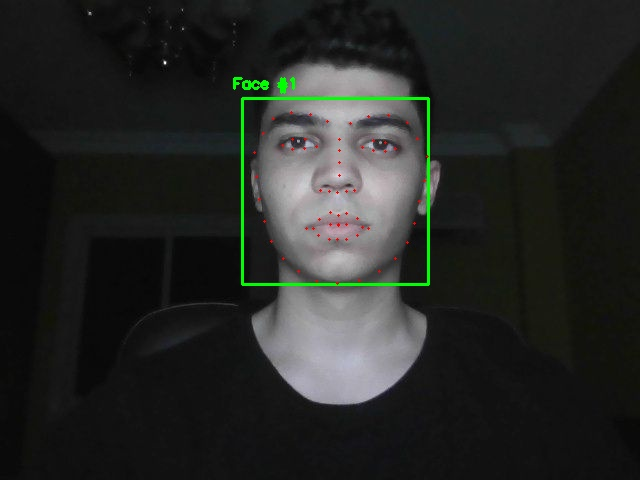

In [228]:
try:
  filename, shape = take_photo('photo1.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

#### Pitch

In [229]:
features = shape.T
pitch_landmarks=pitch_calc(features).reshape(1,-1)


In [230]:
label_P = p_svm_model.predict(pitch_landmarks)
label_P

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  "X does not have valid feature names, but"


array([0.09128821])

#### Yaw

In [231]:
features = shape.T
yaw_landmarks=yaw_calc(features).reshape(1,-1)


In [232]:
label_y = y_rf_model.predict(yaw_landmarks)
label_y

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


array([-0.00630343])

#### Roll

In [233]:
features = shape.T
roll_landmarks=roll_calc(features).reshape(1,-1)

In [234]:
label_r = r_svm_model.predict(yaw_landmarks)
label_r

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  "X does not have valid feature names, but"


array([0.06039082])

#### Applied Image

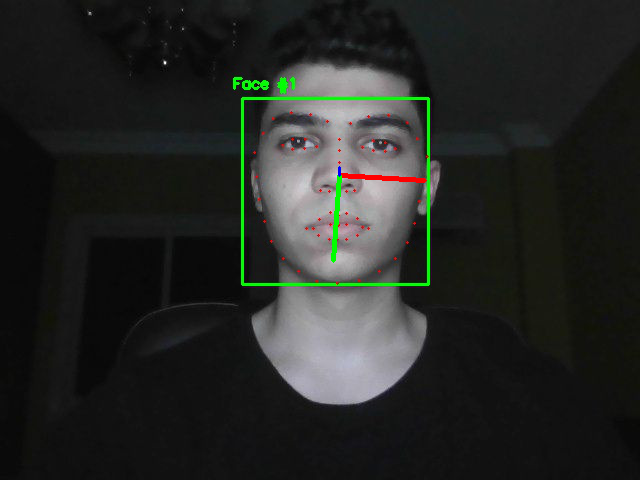

In [235]:
X_min = features [0].min()
X_max = features [0].max()
width = X_max-X_min 

img = imread("photo1.jpg")
X_nose = features.flatten()[30]
Y_nose = features.flatten()[30+68]
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = draw_axis( img, label_y, label_P, label_r, X_nose, Y_nose, roll_color = (0, 0, 255), yaw_color = (0, 255, 0),pitch_color = (255, 0, 0), size = width//2)
cv2_imshow(img)

>> ### 5.2.2. Trail 2

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo2.jpg


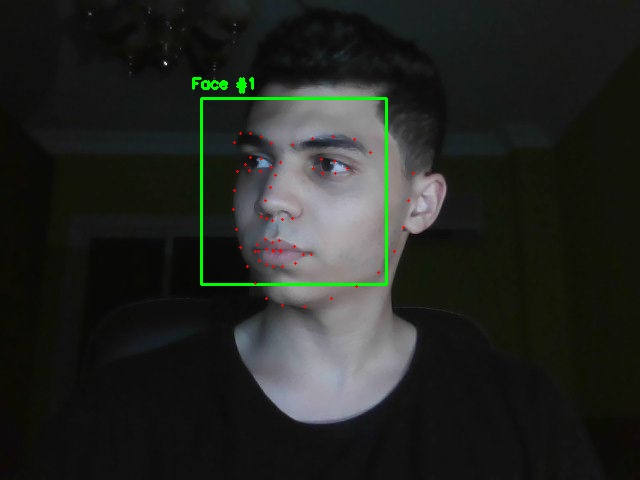

In [239]:
try:
  filename, shape = take_photo('photo2.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

#### Pitch

In [240]:
features = shape.T
pitch_landmarks=pitch_calc(features).reshape(1,-1)


In [241]:
label_P = p_svm_model.predict(pitch_landmarks)
label_P

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  "X does not have valid feature names, but"


array([0.19594008])

#### Yaw

In [242]:
features = shape.T
yaw_landmarks=yaw_calc(features).reshape(1,-1)


In [243]:
label_y = y_rf_model.predict(yaw_landmarks)
label_y

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


array([0.53222063])

#### Roll

In [244]:
features = shape.T
roll_landmarks=roll_calc(features).reshape(1,-1)

In [245]:
label_r = r_svm_model.predict(yaw_landmarks)
label_r

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  "X does not have valid feature names, but"


array([-0.0097856])

#### Applied Image

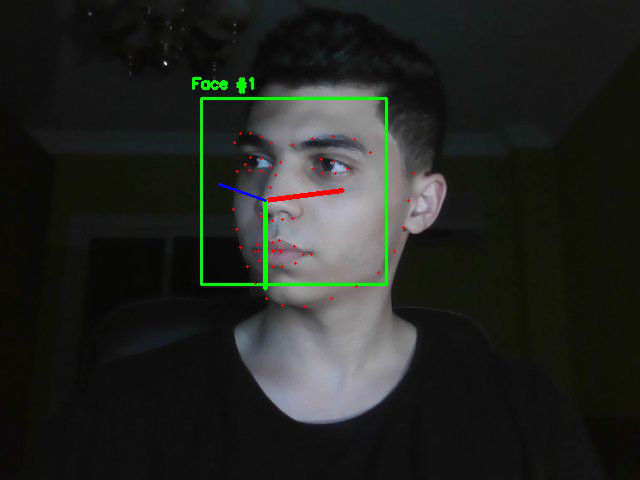

In [247]:
X_min = features [0].min()
X_max = features [0].max()
width = X_max-X_min 

img = imread("photo2.jpg")
X_nose = features.flatten()[30]
Y_nose = features.flatten()[30+68]
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = draw_axis( img, label_y, label_P, label_r, X_nose, Y_nose, roll_color = (0, 0, 255), yaw_color = (0, 255, 0),pitch_color = (255, 0, 0), size = width//2)
cv2_imshow(img)

>> ### 5.2.3. Trail 3

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo3.jpg


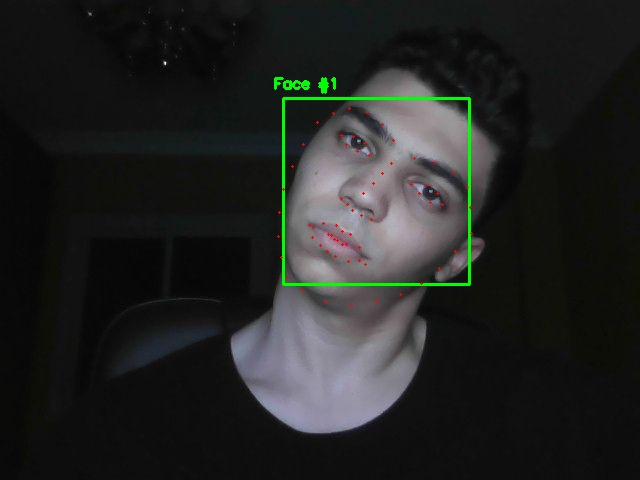

In [248]:
try:
  filename, shape = take_photo('photo3.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

#### Pitch

In [249]:
features = shape.T
pitch_landmarks=pitch_calc(features).reshape(1,-1)


In [250]:
label_P = p_svm_model.predict(pitch_landmarks)
label_P

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  "X does not have valid feature names, but"


array([0.06124514])

#### Yaw

In [251]:
features = shape.T
yaw_landmarks=yaw_calc(features).reshape(1,-1)


In [252]:
label_y = y_rf_model.predict(yaw_landmarks)
label_y

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


array([0.05089851])

#### Roll

In [253]:
features = shape.T
roll_landmarks=roll_calc(features).reshape(1,-1)

In [254]:
label_r = r_svm_model.predict(yaw_landmarks)
label_r

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  "X does not have valid feature names, but"


array([0.42153308])

#### Applied Image

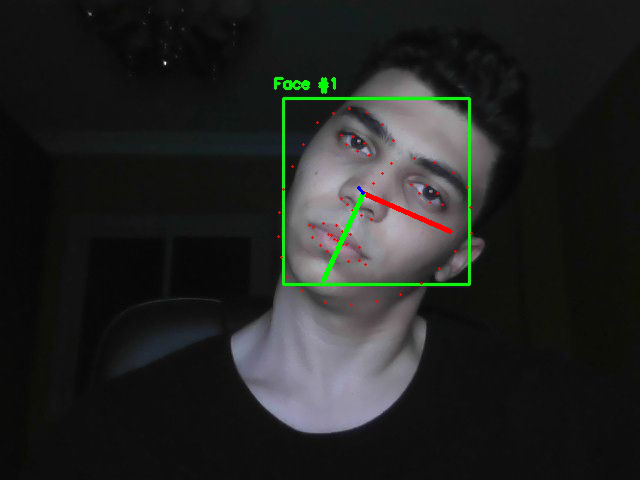

In [256]:
X_min = features [0].min()
X_max = features [0].max()
width = X_max-X_min 

img = imread("photo3.jpg")
X_nose = features.flatten()[30]
Y_nose = features.flatten()[30+68]
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = draw_axis( img, label_y, label_P, label_r, X_nose, Y_nose, roll_color = (0, 0, 255), yaw_color = (0, 255, 0),pitch_color = (255, 0, 0), size = width//2)
cv2_imshow(img)

>> ### 5.2.4. Trail 4

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo4.jpg


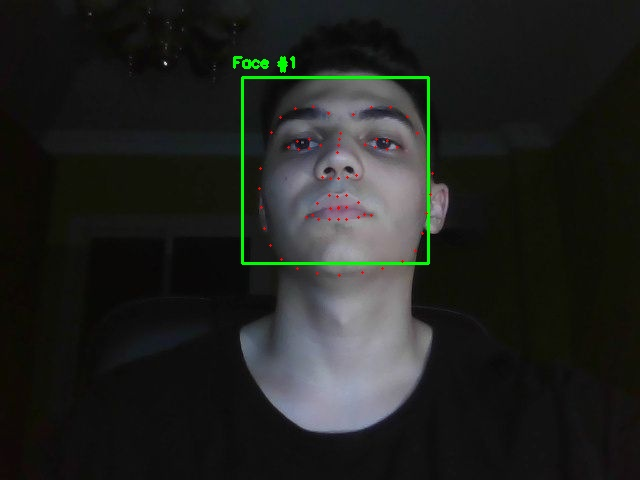

In [257]:
try:
  filename, shape = take_photo('photo4.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

#### Pitch

In [258]:
features = shape.T
pitch_landmarks=pitch_calc(features).reshape(1,-1)


In [259]:
label_P = p_svm_model.predict(pitch_landmarks)
label_P

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  "X does not have valid feature names, but"


array([0.5009196])

#### Yaw

In [260]:
features = shape.T
yaw_landmarks=yaw_calc(features).reshape(1,-1)


In [261]:
label_y = y_rf_model.predict(yaw_landmarks)
label_y

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


array([0.0941213])

#### Roll

In [264]:
features = shape.T
roll_landmarks=roll_calc(features).reshape(1,-1)

In [265]:
label_r = r_svm_model.predict(yaw_landmarks)
label_r

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  "X does not have valid feature names, but"


array([0.13859559])

#### Applied Image

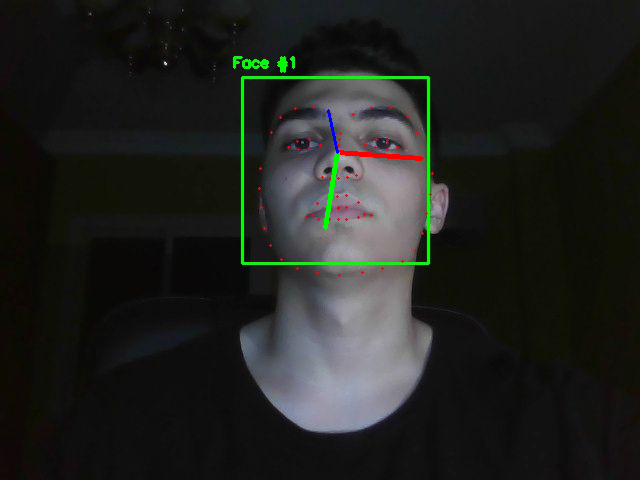

In [266]:
X_min = features [0].min()
X_max = features [0].max()
width = X_max-X_min 

img = imread("photo4.jpg")
X_nose = features.flatten()[30]
Y_nose = features.flatten()[30+68]
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = draw_axis( img, label_y, label_P, label_r, X_nose, Y_nose, roll_color = (0, 0, 255), yaw_color = (0, 255, 0),pitch_color = (255, 0, 0), size = width//2)
cv2_imshow(img)

>> ### 5.2.5. Trail 5

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo5.jpg


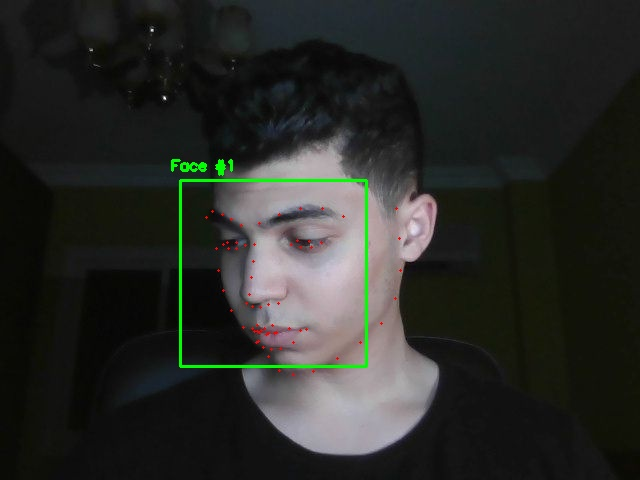

In [267]:
try:
  filename, shape = take_photo('photo5.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

#### Pitch

In [268]:
features = shape.T
pitch_landmarks=pitch_calc(features).reshape(1,-1)


In [269]:
label_P = p_svm_model.predict(pitch_landmarks)
label_P

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  "X does not have valid feature names, but"


array([-0.25574313])

#### Yaw

In [270]:
features = shape.T
yaw_landmarks=yaw_calc(features).reshape(1,-1)


In [271]:
label_y = y_rf_model.predict(yaw_landmarks)
label_y

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


array([0.48735044])

#### Roll

In [272]:
features = shape.T
roll_landmarks=roll_calc(features).reshape(1,-1)

In [273]:
label_r = r_svm_model.predict(yaw_landmarks)
label_r

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  "X does not have valid feature names, but"


array([-0.14073261])

#### Applied Image

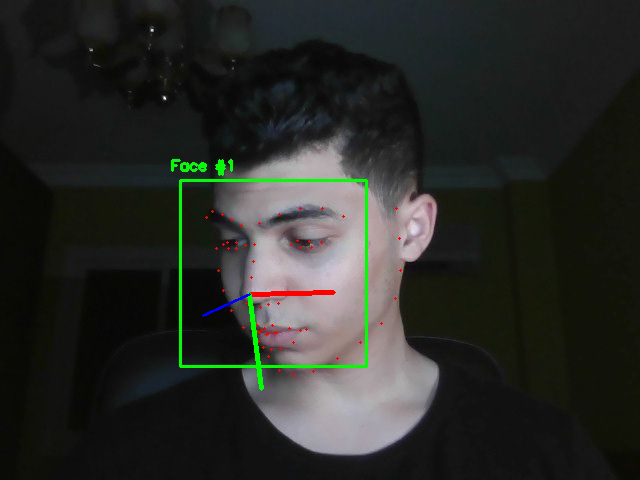

In [274]:
X_min = features [0].min()
X_max = features [0].max()
width = X_max-X_min 

img = imread("photo5.jpg")
X_nose = features.flatten()[30]
Y_nose = features.flatten()[30+68]
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = draw_axis( img, label_y, label_P, label_r, X_nose, Y_nose, roll_color = (0, 0, 255), yaw_color = (0, 255, 0),pitch_color = (255, 0, 0), size = width//2)
cv2_imshow(img)

<a name = "Video"></a>

> ## 5.3. Video 

In [275]:
def read_video(videoInputPath):
  cap = cv2.VideoCapture(InputvideoPath)
  frames_array = []
  if (cap.isOpened()== False): 
    print("Error opening video stream or file")

  while (cap.isOpened()):
      ret, img = cap.read()
      if ret==False:
        break 
      frames_array.append(img)
  return frames_array

In [276]:
def video_write(videoOutputPath,frames_array):
  fourcc = cv2.VideoWriter_fourcc(*"MP4V")
  h, w, l = frames_array[0].shape 
  writer = cv2.VideoWriter(videoOutputPath, fourcc, 25.0,(w, h))

  for img in frames_array:  
    # draw face bounding box on image
    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 1)

    # loop over the face detections
    for (i, rect) in enumerate(faces):
      # determine the facial landmarks for the face region, then
      # convert the facial landmark (x, y)-coordinates to a NumPy
      # array
      shape = predictor(gray, rect)
      shape = shape_to_np(shape)
    features = shape.T 
    X_min = features [0].min()


    #drawing axes
    X_max = features [0].max()
    width = X_max-X_min 

    # predict pitch
    
    pitch_landmarks=pitch_calc(features).reshape(1,-1)
    label_P = p_svm_model.predict(pitch_landmarks)
    

    #predict yaw
    yaw_landmarks=yaw_calc(features).reshape(1,-1)
    label_y = y_rf_model.predict(yaw_landmarks)

    #predict roll
    roll_landmarks = roll_calc(features).reshape(1,-1)
    label_r = r_svm_model.predict(roll_landmarks)

    X_nose = features.flatten()[30]
    Y_nose = features.flatten()[30+68]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = draw_axis( img, label_y, label_P, label_r, X_nose, Y_nose, (0,0,255),(0,255,0) ,(255,0,0) ,  width//2)
    writer.write(img)
  writer.release()


In [ ]:
OutputvideoPath= video_path + "T3_out.mp4"
InputvideoPath=video_path +"Trial_03.mp4"
print(InputvideoPath)
frames_array = read_video(InputvideoPath)
video_write(OutputvideoPath, frames_array)

drive/My Drive/AI-Pro Track ITI/ML1/Project/Video/Original_video.mp4


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"